In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import pandas as pd
import matplotlib.dates as mpl_dates
import scipy.stats as stats
from matplotlib.ticker import StrMethodFormatter

### Functions

In [2]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = age
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var

def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

def running_mean(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)

In [3]:
def plotCSNS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1 #actually lon
    fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
    tmask = mesh.tmask[0]
    
    lons = data.init_lat[(data.final_section != 0)]
    
    f_lons = mesh.gphif[0,:, latgridf]
    u_lons = mesh.gphiv[0,:, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Latitude (°W)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

## Import data

In [4]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

lonW = 308
lonE = 327
latgridi = 300
latgridf = latgridi-1
fmask = mesh.fmask[0, :, latgridi]
tmask = mesh.tmask[0]
    
lons = data.init_lon[(data.final_section != 0)]
    
f_lons = mesh.glamf[0, latgridi]
u_lons = mesh.glamv[0, latgridi]
w_depths = mesh.gdepw_1d

m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [5]:
#Importing data and calculating section transport 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

files = ['forpr_ros3','backadm_ros3','backvs_ros3']
namen = ['datafvs']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6,7,8]

date = dt.datetime(2016,12,10)
enddate = dt.datetime(2021,12,27)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     
dicts = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/' + date + '_s1t50/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        
    dicts[file] = dict_i
    
dict_sectiontransp = {}

for file in files:
    st_dict = {}
    for var in dicts[file].keys():
        if var not in st_dict:
            st_dict[var] = []
        for section in sectionnum:
            st_dict[var].append(get_datat(dicts[file][var],section,starttime,endtime))
        dict_sectiontransp[file] = st_dict

dict_age = {}

for file in files:
    a_dict = {}
    
    for date in dicts[file].keys():
        if date not in a_dict:
            a_dict[date] = []
        for section in sectionnum:
            allvar = get_secdata(dicts[file][date],section)
            a_dict[date].append(np.mean(allvar['final_age'][allvar['final_age']>=24]))
    dict_age[file] = a_dict

age_2018 = {}

for file in files:
    
    if file not in age_2018:
        age_2018[file] = {}
    
    for section in sectionnum:
        
        if section not in age_2018[file]:
            
            age_2018[file][section] = []
            
        for date in dicts[file].keys():
            
            age_2018[file][section].append(dict_age[file][date][section])
            
transp_2018 = {}

for file in files:
    
    transp_2018[file] = []
    
    for date in dates:
        try:
            transp_2018[file].append(np.sum(dict_sectiontransp[file][date][2:]))
        except:
            pass
        
sectransp_2018 = {}

for file in files:
    sectransp_2018[file] = {}
    
    for section in sectionnum:
        if section not in sectransp_2018[file]:
            sectransp_2018[file][section] = []
            
        for date in dates:
            try:
                sectransp_2018[file][section].append(dict_sectiontransp[file][date][section])
            except:
                print(date)
                pass


In [6]:
dict_secdata = {}

for file in files:
    
    if file not in dict_secdata:
        dict_secdata[file] = {}
    
    
    for section in sectionnum:
        
        if section not in dict_secdata[file]:
            
            dict_secdata[file][section] = {}
            
        for date in dicts[file].keys():
            
            dict_secdata[file][section] = get_secdata(dicts[file][date],section)


In [7]:
dict_secdata['forpr_ros3'][0]['final_salt']

<xarray.DataArray 'final_salt' (ntraj: 12268)>
[12268 values with dtype=float32]
Dimensions without coordinates: ntraj
Attributes:
    title:     What is final_salt ?
    longname:  Final salinity
    units:     psu

In [8]:
month_avg = np.zeros([12,len(sectransp_2018['forpr_ros3'].keys())])

for sectionnum in sectransp_2018['forpr_ros3'].keys():
    intermed = sectransp_2018['forpr_ros3'][sectionnum]
    for month in range(1,13):
        dates = [index for index, date in enumerate(datelist_vs) if date.month == month]
        selected_elements = [sectransp_2018['forpr_ros3'][sectionnum][index] for index in dates]
        month_avg[month-1,sectionnum] = np.mean(selected_elements)
    

In [9]:
dates = [index for index, date in enumerate(datelist_vs) if date.month == 1]
selected_elements = [sectransp_2018['forpr_ros3'][0][index] for index in dates]
date_jan = [datelist_vs for index in dates]

date = dt.datetime(2018,1,1)
enddate = dt.datetime(2019,1,1)

dates = []
datelist_yr = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_yr.append(date)
    date+=dt.timedelta(days=31) 

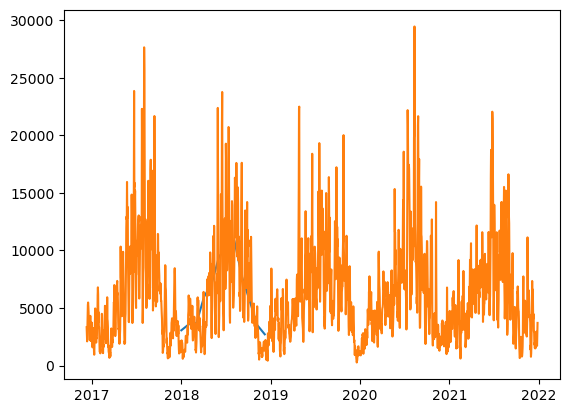

In [10]:
plt.plot(datelist_yr,month_avg[:,4])
plt.plot(datelist_vs,sectransp_2018['forpr_ros3'][4])

### Shifting functions

In [11]:
def shift_time(dfr,dfr_age,datelist,base,factor):
    shifted_time = [date + dt.timedelta(days=base+factor*dfr_age[i]/24) for i,date in enumerate(datelist)]
    dfr = pd.DataFrame({'Transport':dfr.values,'Shifted_Time': shifted_time},index=dfr.index)
    return dfr

def merge(dfr,dfr2):
    """Aligns shifted dateframes to calculate correlation

    Args:
        dfr : Forward dataframe
        dfr2 (_type_): Backward dataframe

    Returns:
        _type_: Aligned, shifted dataframes and correlation between the 2.
    """
    
    oidx = dfr.index
    ndfr = dfr.set_index('Shifted_Time')
    nidx = ndfr.index
    
    step1 = ndfr.reindex(nidx.union(oidx)) # Creates dataframe with row of each old and new index ( no overlap - 128 rows now)
    step2 = step1.sort_index() # Sorts into chronological order
    step3 = step2.interpolate(axis=0) # Interpolates in between (since dates dont line up)
    fdfr = step3
    
    #Same for 2nd dataframe
    oidx2 = dfr2.index
    ndfr2 = dfr2.set_index('Shifted_Time')
    nidx2 = ndfr2.index
    
    step1 = ndfr2.reindex(nidx2.union(oidx2))
    step2 = step1.sort_index()
    step3 = step2.interpolate(axis=0)
    fdfr2 = step3
    
    corr = fdfr.Transport.corr(fdfr2.Transport) #Correlation ignores nan values
    
    avg = 0.5*(fdfr.Transport + fdfr2.Transport)
    return fdfr,fdfr2,corr,avg

### Import density data

In [12]:
# Importing density and tidal data

density_ros = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_2016-22_rosarioNS.csv')
dens_diff_ros = np.array(density_ros.south - density_ros.north)

tides_1d = pd.read_csv('../notebooks/day_avg_tide_BP_16-22.csv')
tides = tides_1d['vozocrtx'].rolling(4, center=True).mean()
# tides_ros = pd.read_csv('low_pass_tide_18-22.csv')

date = dt.datetime(2016,1,1)
enddate = dt.datetime(2022,12,31)
datelist_tides = []

while date <= enddate:
    datelist_tides.append(date)
    date+=dt.timedelta(days=1)

#Confirm dates are same length

print(len(datelist_tides))
print(tides.shape)   
 
date = dt.datetime(2016,1,1)
enddate = dt.datetime(2022,12,31)
datelist_dens = []

while date <= enddate:
    datelist_dens.append(date)
    date+=dt.timedelta(days=1)
    
dens_diff_ros
print(len(datelist_dens),)

2557
(2557,)
2557


In [13]:
wind = pd.read_csv('../notebooks/day_avg_wind_16-22.csv')
x = wind['time']
y = wind['wind']

date = dt.datetime(2016,1,1)
enddate = dt.datetime(2022,12,31)
datelist_winds = []

while date <= enddate:
    datelist_winds.append(date)
    date+=dt.timedelta(days=1)
    
y_mean4 = y.rolling(window=4, center=True).mean()

In [14]:
len(datelist_winds),len(y_mean4)

(2557, 2557)

#### Rosario to adm

In [15]:
PRtoadm_rosl = sectransp_2018['forpr_ros3'][2]
PRtoadm_rosbl = sectransp_2018['backadm_ros3'][4]

PRtoadm_ros = pd.Series(PRtoadm_rosl,index=datelist_vs)
PRtoadm_rosb = pd.Series(PRtoadm_rosbl,index=datelist_vs)

In [16]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm_ros,age_2018['forpr_ros3'][2],datelist_vs,base,factor)
        dfr2 = shift_time(PRtoadm_rosb,age_2018['backadm_ros3'][4],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.595:
            print (base, factor, corr_arr[i, j])

-1.0 0.20000000000000107 0.6134471870019035
-0.95 0.20000000000000107 0.6141062033508613
-0.8999999999999999 0.15000000000000102 0.5965995191035859
-0.8999999999999999 0.20000000000000107 0.6165634039046451
-0.8499999999999999 0.15000000000000102 0.5999588917771589
-0.8499999999999999 0.20000000000000107 0.6161236947301135
-0.7999999999999998 0.15000000000000102 0.6019642837149143
-0.7999999999999998 0.20000000000000107 0.6178875089820812
-0.7499999999999998 0.15000000000000102 0.6045028892284918
-0.7499999999999998 0.20000000000000107 0.618635247621217
-0.6999999999999997 0.15000000000000102 0.6019911757426616
-0.6999999999999997 0.20000000000000107 0.6161185260978407
-0.6499999999999997 0.15000000000000102 0.603446973695985
-0.6499999999999997 0.20000000000000107 0.6160302631219547
-0.5999999999999996 0.15000000000000102 0.6019456104774006
-0.5999999999999996 0.20000000000000107 0.6094896528860785
-0.5499999999999996 0.15000000000000102 0.5987353183162476
-0.5499999999999996 0.200000

In [17]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-0.75] [0.2]


0.618635247621217


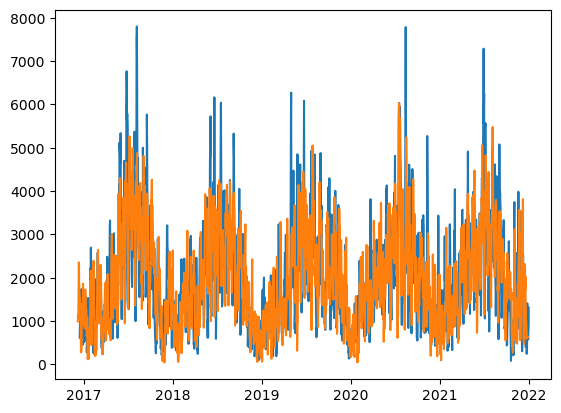

In [18]:
PRtoadm_ros_sh = shift_time(PRtoadm_ros,age_2018['forpr_ros3'][2],datelist_vs,base_adm[0],factor_adm[0])
PRtoadm_rosb_sh = shift_time(PRtoadm_rosb,age_2018['backadm_ros3'][4],datelist_vs,-base_adm[0],-factor_adm[0])

PRtoadm_ros_m,PRtoadm_rosb_m,c,PRtoadm_ros_avg = merge(PRtoadm_ros_sh,PRtoadm_rosb_sh)
print(c)

plt.plot(PRtoadm_ros_m.Transport)
plt.plot(PRtoadm_rosb_m.Transport)

### Split into single years

#### Only 2017

-1.0 0.15000000000000102 0.682260705309288
-1.0 0.20000000000000107 0.7024470443652207
-1.0 0.2500000000000011 0.6527367718418798
-0.95 0.15000000000000102 0.6815343528077523
-0.95 0.20000000000000107 0.7021170463876444
-0.95 0.2500000000000011 0.650945497492129
-0.95 0.9500000000000017 0.6510911090813856
-0.8999999999999999 0.15000000000000102 0.6942969499898561
-0.8999999999999999 0.20000000000000107 0.699671399557174
-0.8999999999999999 0.9500000000000017 0.6543688347800473
-0.8499999999999999 0.15000000000000102 0.6942181648274369
-0.8499999999999999 0.20000000000000107 0.6970079666614348
-0.8499999999999999 0.9500000000000017 0.6504381551130783
-0.7999999999999998 0.15000000000000102 0.6907577733506077
-0.7999999999999998 0.20000000000000107 0.6965526602468409
-0.7499999999999998 0.15000000000000102 0.6890934323506804
-0.7499999999999998 0.20000000000000107 0.6982884658800251
-0.7499999999999998 0.9500000000000017 0.6618792344362407
-0.6999999999999997 0.15000000000000102 0.687568

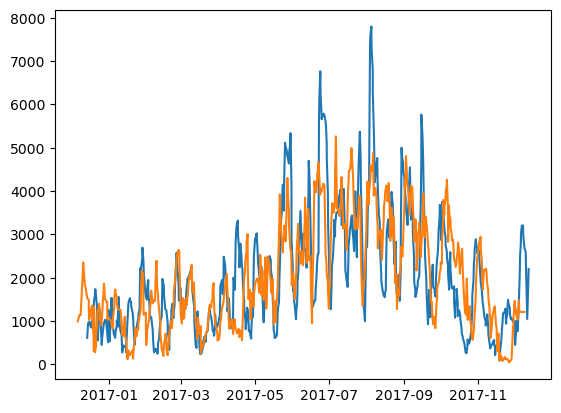

In [19]:
PRtoadm2017_rosl = sectransp_2018['forpr_ros3'][2][0:365]
PRtoadm2017_rosbl = sectransp_2018['backadm_ros3'][4][0:365]

PRtoadm2017_ros = pd.Series(PRtoadm2017_rosl,index=datelist_vs[0:365])
PRtoadm2017_rosb = pd.Series(PRtoadm2017_rosbl,index=datelist_vs[0:365])

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm2017_ros,age_2018['forpr_ros3'][2][0:365],datelist_vs[0:365],base,factor)
        dfr2 = shift_time(PRtoadm2017_rosb,age_2018['backadm_ros3'][4][0:365],datelist_vs[0:365],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.65:
            print (base, factor, corr_arr[i, j])
            
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

PRtoadm2017_ros_sh = shift_time(PRtoadm2017_ros,age_2018['forpr_ros3'][2][0:365],datelist_vs[0:365],base_adm[0],factor_adm[0])
PRtoadm2017_rosb_sh = shift_time(PRtoadm2017_rosb,age_2018['backadm_ros3'][4][0:365],datelist_vs[0:365],-base_adm[0],-factor_adm[0])

PRtoadm2017_ros_m,PRtoadm2017_rosb_m,c,PRtoadm2017_ros_avg = merge(PRtoadm2017_ros_sh,PRtoadm2017_rosb_sh)
print(c)

plt.plot(PRtoadm2017_ros_m.Transport)
plt.plot(PRtoadm2017_rosb_m.Transport)

#### Now do this same for only 2018

In [20]:
PRtoadm2018_rosl = sectransp_2018['forpr_ros3'][2][365:750]
PRtoadm2018_rosbl = sectransp_2018['backadm_ros3'][4][365:750]

PRtoadm2018_ros = pd.Series(PRtoadm2018_rosl,index=datelist_vs[365:750])
PRtoadm2018_rosb = pd.Series(PRtoadm2018_rosbl,index=datelist_vs[365:750])

In [21]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm2018_ros,age_2018['forpr_ros3'][2][365:750],datelist_vs[365:750],base,factor)
        dfr2 = shift_time(PRtoadm2018_rosb,age_2018['backadm_ros3'][4][365:750],datelist_vs[365:750],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.8:
            print (base, factor, corr_arr[i, j])

In [22]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-0.8] [0.15]


0.6550074656313384


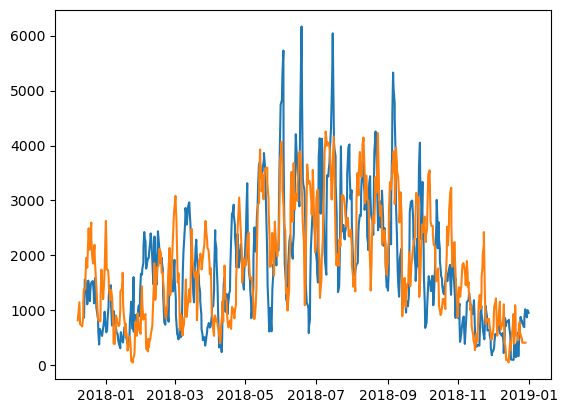

In [23]:
PRtoadm2018_ros_sh = shift_time(PRtoadm2018_ros,age_2018['forpr_ros3'][2][365:750],datelist_vs[365:750],base_adm[0],factor_adm[0])
PRtoadm2018_rosb_sh = shift_time(PRtoadm2018_rosb,age_2018['backadm_ros3'][4][365:750],datelist_vs[365:750],-base_adm[0],-factor_adm[0])

PRtoadm2018_ros_m,PRtoadm2018_rosb_m,c,PRtoadm2018_ros_avg = merge(PRtoadm2018_ros_sh,PRtoadm2018_rosb_sh)
print(c)

plt.plot(PRtoadm2018_ros_m.Transport)
plt.plot(PRtoadm2018_rosb_m.Transport)

#### Now do this for only 2019

In [24]:
PRtoadm2019_rosl = sectransp_2018['forpr_ros3'][2][750:1110]
PRtoadm2019_rosbl = sectransp_2018['backadm_ros3'][4][750:1110]

PRtoadm2019_ros = pd.Series(PRtoadm2019_rosl,index=datelist_vs[750:1110])
PRtoadm2019_rosb = pd.Series(PRtoadm2019_rosbl,index=datelist_vs[750:1110])

In [25]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm2019_ros,age_2018['forpr_ros3'][2][750:1110],datelist_vs[750:1110],base,factor)
        dfr2 = shift_time(PRtoadm2019_rosb,age_2018['backadm_ros3'][4][750:1110],datelist_vs[750:1110],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.57:
            print (base, factor, corr_arr[i, j])

-1.0 0.3500000000000012 0.5762973272730353
-0.95 0.3500000000000012 0.5772148908053214
-0.95 0.40000000000000124 0.5711493272782863
-0.8999999999999999 0.3500000000000012 0.5777127981753594
-0.8499999999999999 0.3500000000000012 0.5717322542979336
-0.7499999999999998 0.3500000000000012 0.5758560027660319
-0.6999999999999997 0.3500000000000012 0.5708110013816076
-0.6499999999999997 0.3500000000000012 0.5768378802871007
-0.5999999999999996 0.3500000000000012 0.570875670845368
-0.49999999999999956 0.3500000000000012 0.5749281616465954
-0.4499999999999995 0.3500000000000012 0.5796139435959509
-0.39999999999999947 0.3500000000000012 0.5738270850140776
-0.3499999999999994 0.3500000000000012 0.5778686135893547
-0.2999999999999994 0.3500000000000012 0.5788510131111584
-0.24999999999999933 0.3500000000000012 0.5758464559731834
-0.1999999999999993 0.30000000000000115 0.5704286483682088
-0.1999999999999993 0.3500000000000012 0.5730421755092
-0.14999999999999925 0.30000000000000115 0.5731959205107

In [26]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[0.55] [0.3]


0.5859375888174071


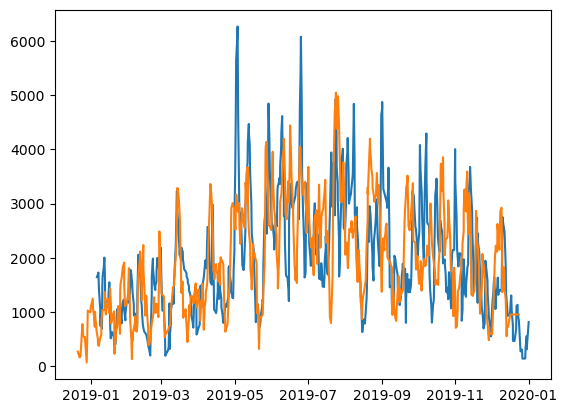

In [27]:
PRtoadm2019_ros_sh = shift_time(PRtoadm2019_ros,age_2018['forpr_ros3'][2][750:1110],datelist_vs[750:1110],base_adm[0],factor_adm[0])
PRtoadm2019_rosb_sh = shift_time(PRtoadm2019_rosb,age_2018['backadm_ros3'][4][750:1110],datelist_vs[750:1110],-base_adm[0],-factor_adm[0])

PRtoadm2019_ros_m,PRtoadm2019_rosb_m,c,PRtoadm2019_ros_avg = merge(PRtoadm2019_ros_sh,PRtoadm2019_rosb_sh)
print(c)

plt.plot(PRtoadm2019_ros_m.Transport)
plt.plot(PRtoadm2019_rosb_m.Transport)

#### Now for 2020

In [28]:
PRtoadm2020_rosl = sectransp_2018['forpr_ros3'][2][1110:1460]
PRtoadm2020_rosbl = sectransp_2018['backadm_ros3'][4][1110:1460]

PRtoadm2020_ros = pd.Series(PRtoadm2020_rosl,index=datelist_vs[1110:1460])
PRtoadm2020_rosb = pd.Series(PRtoadm2020_rosbl,index=datelist_vs[1110:1460])

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm2020_ros,age_2018['forpr_ros3'][2][1110:1460],datelist_vs[1110:1460],base,factor)
        dfr2 = shift_time(PRtoadm2020_rosb,age_2018['backadm_ros3'][4][1110:1460],datelist_vs[1110:1460],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.57:
            print (base, factor, corr_arr[i, j])
            
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

-1.0 0.20000000000000107 0.6209366878136214
-1.0 0.2500000000000011 0.6603419037308395
-1.0 0.30000000000000115 0.6506753008996613
-1.0 0.3500000000000012 0.5987796774813879
-1.0 0.40000000000000124 0.5706705668893273
-0.95 0.20000000000000107 0.6270608267971051
-0.95 0.2500000000000011 0.6483629464328978
-0.95 0.30000000000000115 0.646469131980799
-0.95 0.3500000000000012 0.5952257255738936
-0.8999999999999999 0.20000000000000107 0.6310598446377154
-0.8999999999999999 0.2500000000000011 0.6498182448550357
-0.8999999999999999 0.30000000000000115 0.6406121296592753
-0.8999999999999999 0.3500000000000012 0.5999334753115627
-0.8499999999999999 0.20000000000000107 0.6268682661903422
-0.8499999999999999 0.2500000000000011 0.643134145167998
-0.8499999999999999 0.30000000000000115 0.6362855282202504
-0.8499999999999999 0.3500000000000012 0.5981421255925088
-0.7999999999999998 0.20000000000000107 0.6383125113374131
-0.7999999999999998 0.2500000000000011 0.6487446449236279
-0.7999999999999998 0

0.6808523830688374


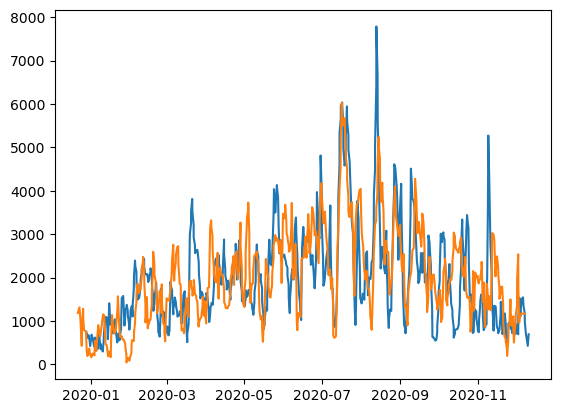

In [29]:
PRtoadm2020_ros_sh = shift_time(PRtoadm2020_ros,age_2018['forpr_ros3'][2][1110:1460],datelist_vs[1110:1460],base_adm[0],factor_adm[0])
PRtoadm2020_rosb_sh = shift_time(PRtoadm2020_rosb,age_2018['backadm_ros3'][4][1110:1460],datelist_vs[1110:1460],-base_adm[0],-factor_adm[0])

PRtoadm2020_ros_m,PRtoadm2020_rosb_m,c,PRtoadm2020_ros_avg = merge(PRtoadm2020_ros_sh,PRtoadm2020_rosb_sh)
print(c)

plt.plot(PRtoadm2020_ros_m.Transport)
plt.plot(PRtoadm2020_rosb_m.Transport)

#### Now for 2021

In [30]:
PRtoadm2021_rosl = sectransp_2018['forpr_ros3'][2][1460:]
PRtoadm2021_rosbl = sectransp_2018['backadm_ros3'][4][1460:]

PRtoadm2021_ros = pd.Series(PRtoadm2021_rosl,index=datelist_vs[1460:])
PRtoadm2021_rosb = pd.Series(PRtoadm2021_rosbl,index=datelist_vs[1460:])

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm2021_ros,age_2018['forpr_ros3'][2][1460:],datelist_vs[1460:],base,factor)
        dfr2 = shift_time(PRtoadm2021_rosb,age_2018['backadm_ros3'][4][1460:],datelist_vs[1460:],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.57:
            print (base, factor, corr_arr[i, j])
            
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

-1.0 0.20000000000000107 0.5729763819284602
-0.95 0.20000000000000107 0.5799883611944041
-0.8999999999999999 0.15000000000000102 0.5709275022174856
-0.8999999999999999 0.20000000000000107 0.5838827625420334
-0.8499999999999999 0.15000000000000102 0.5760436113006985
-0.8499999999999999 0.20000000000000107 0.5926740794875356
-0.7999999999999998 0.15000000000000102 0.5721840263938961
-0.7999999999999998 0.20000000000000107 0.5940202998606867
-0.7499999999999998 0.20000000000000107 0.5825203536847656
-0.6999999999999997 0.20000000000000107 0.5793864448343177
-0.6499999999999997 0.15000000000000102 0.5717830480619661
-0.6499999999999997 0.20000000000000107 0.5786549080110281
-0.5999999999999996 0.15000000000000102 0.5708992650753353
-0.5999999999999996 0.20000000000000107 0.5709602073570669
-0.3499999999999994 0.15000000000000102 0.5736169583149043
-0.2999999999999994 0.15000000000000102 0.5790558315472552
-0.24999999999999933 0.15000000000000102 0.5820032352776672
-0.1999999999999993 0.150

0.598361039138628


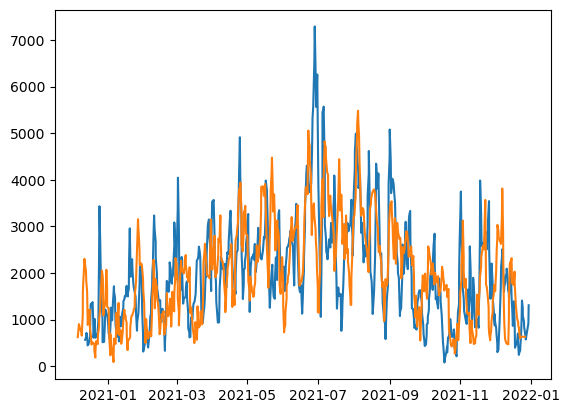

In [31]:
PRtoadm2021_ros_sh = shift_time(PRtoadm2021_ros,age_2018['forpr_ros3'][2][1460:],datelist_vs[1460:],base_adm[0],factor_adm[0])
PRtoadm2021_rosb_sh = shift_time(PRtoadm2021_rosb,age_2018['backadm_ros3'][4][1460:],datelist_vs[1460:],-base_adm[0],-factor_adm[0])

PRtoadm2021_ros_m,PRtoadm2021_rosb_m,c,PRtoadm2021_ros_avg = merge(PRtoadm2021_ros_sh,PRtoadm2021_rosb_sh)
print(c)

plt.plot(PRtoadm2021_ros_m.Transport)
plt.plot(PRtoadm2021_rosb_m.Transport)

### PR to VicSill

In [32]:
PRtovs_rosl = sectransp_2018['forpr_ros3'][4]
PRtovs_rosbl = sectransp_2018['backvs_ros3'][4]

PRtovs_ros = pd.Series(PRtovs_rosl,index=datelist_vs)
PRtovs_rosb = pd.Series(PRtovs_rosbl,index=datelist_vs)

In [33]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs_ros,age_2018['forpr_ros3'][4],datelist_vs,base,factor)
        dfr2 = shift_time(PRtovs_rosb,age_2018['backvs_ros3'][4],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.68:
            print (base, factor, corr_arr[i, j])

-1.0 0.2500000000000011 0.7325336247425105
-1.0 0.30000000000000115 0.7179785434184928
-0.95 0.2500000000000011 0.7310162412347259
-0.95 0.30000000000000115 0.7103502039954206
-0.8999999999999999 0.20000000000000107 0.6838486549566244
-0.8999999999999999 0.2500000000000011 0.7310166769936179
-0.8999999999999999 0.30000000000000115 0.7061260427139904
-0.8499999999999999 0.20000000000000107 0.6893627421980109
-0.8499999999999999 0.2500000000000011 0.7291223295972036
-0.8499999999999999 0.30000000000000115 0.7040888935453391
-0.7999999999999998 0.20000000000000107 0.6936035140457749
-0.7999999999999998 0.2500000000000011 0.7320561670492404
-0.7999999999999998 0.30000000000000115 0.7027620914408726
-0.7499999999999998 0.20000000000000107 0.6972364300202912
-0.7499999999999998 0.2500000000000011 0.7344922554226359
-0.7499999999999998 0.30000000000000115 0.6964307996002491
-0.6999999999999997 0.20000000000000107 0.6979842814440604
-0.6999999999999997 0.2500000000000011 0.7322324237547829
-0.

In [34]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-0.75] [0.25]


0.7344922554226359


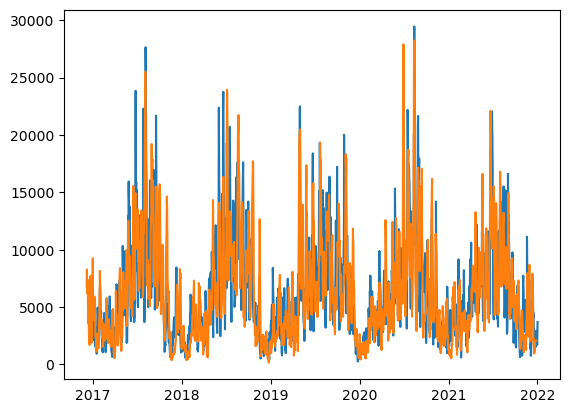

In [35]:
PRtovs_ros_sh = shift_time(PRtovs_ros,age_2018['forpr_ros3'][4],datelist_vs,base_adm[0],factor_adm[0])
PRtovs_rosb_sh = shift_time(PRtovs_rosb,age_2018['backvs_ros3'][4],datelist_vs,-base_adm[0],-factor_adm[0])

PRtovs_ros_m,PRtovs_rosb_m,c,PRtovs_ros_avg = merge(PRtovs_ros_sh,PRtovs_rosb_sh)
print(c)

plt.plot(PRtovs_ros_m.Transport)
plt.plot(PRtovs_rosb_m.Transport)

### Split into years

### 2017

-1.0 0.20000000000000107 0.7610843511718882
-1.0 0.2500000000000011 0.7763198426842869
-0.95 0.20000000000000107 0.7615233814859689
-0.95 0.2500000000000011 0.7630359475334423
-0.8999999999999999 0.20000000000000107 0.7648934420523167
-0.8999999999999999 0.2500000000000011 0.758683328570182
-0.8499999999999999 0.20000000000000107 0.7628555302688944
-0.8499999999999999 0.2500000000000011 0.7541300583776663
-0.7999999999999998 0.20000000000000107 0.7582768697304704
-0.7999999999999998 0.2500000000000011 0.7523415587675286
-0.7499999999999998 0.20000000000000107 0.7555752947107308
-0.7499999999999998 0.2500000000000011 0.7507323016133077
-0.6999999999999997 0.20000000000000107 0.7510759894839687
-0.6999999999999997 0.2500000000000011 0.7443611153684692
-0.6499999999999997 0.20000000000000107 0.7624439880334822
-0.6499999999999997 0.2500000000000011 0.7449211531184489
-0.5999999999999996 0.20000000000000107 0.7717712498882354
-0.5999999999999996 0.2500000000000011 0.741380026546958
-0.5499

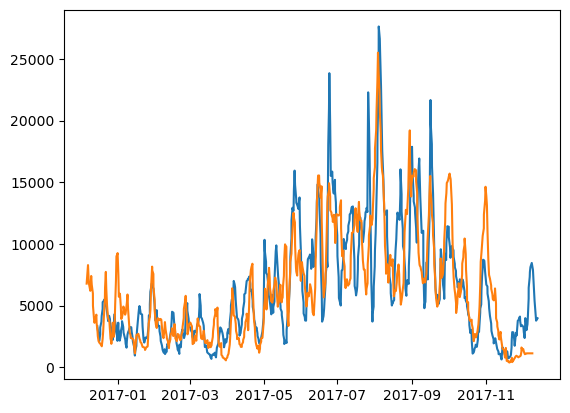

In [36]:
PRtovs2017_rosl = sectransp_2018['forpr_ros3'][4][0:365]
PRtovs2017_rosbl = sectransp_2018['backvs_ros3'][4][0:365]

PRtovs2017_ros = pd.Series(PRtovs2017_rosl,index=datelist_vs[0:365])
PRtovs2017_rosb = pd.Series(PRtovs2017_rosbl,index=datelist_vs[0:365])

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs2017_ros,age_2018['forpr_ros3'][4][0:365],datelist_vs[0:365],base,factor)
        dfr2 = shift_time(PRtovs2017_rosb,age_2018['backvs_ros3'][4][0:365],datelist_vs[0:365],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.73:
            print (base, factor, corr_arr[i, j])
            
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

PRtovs2017_ros_sh = shift_time(PRtovs2017_ros,age_2018['forpr_ros3'][4][0:365],datelist_vs[0:365],base_adm[0],factor_adm[0])
PRtovs2017_rosb_sh = shift_time(PRtovs2017_rosb,age_2018['backvs_ros3'][4][0:365],datelist_vs[0:365],-base_adm[0],-factor_adm[0])

PRtovs2017_ros_m,PRtovs2017_rosb_m,c,PRtovs2017_ros_avg = merge(PRtovs2017_ros_sh,PRtovs2017_rosb_sh)
print(c)

plt.plot(PRtovs2017_ros_m.Transport)
plt.plot(PRtovs2017_rosb_m.Transport)

#### Now do this for only 2018

In [37]:
PRtovs2018_rosl = sectransp_2018['forpr_ros3'][4][365:750]
PRtovs2018_rosbl = sectransp_2018['backvs_ros3'][4][365:750]

PRtovs2018_ros = pd.Series(PRtovs2018_rosl,index=datelist_vs[365:750])
PRtovs2018_rosb = pd.Series(PRtovs2018_rosbl,index=datelist_vs[365:750])

In [38]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs2018_ros,age_2018['forpr_ros3'][4][365:750],datelist_vs[365:750],base,factor)
        dfr2 = shift_time(PRtovs2018_rosb,age_2018['backvs_ros3'][4][365:750],datelist_vs[365:750],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.73:
            print (base, factor, corr_arr[i, j])

-1.0 0.30000000000000115 0.7383132790320881
-0.7499999999999998 0.2500000000000011 0.7303184671278201
-0.6499999999999997 0.2500000000000011 0.7314656453815972
-0.5999999999999996 0.2500000000000011 0.7307758320789479
-0.39999999999999947 0.2500000000000011 0.7304450300179869
-0.3499999999999994 0.2500000000000011 0.7342245171321491
0.15000000000000102 0.20000000000000107 0.7317687809152376
0.20000000000000107 0.20000000000000107 0.7339911066854952


In [39]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-1.] [0.3]


0.7383132790320881


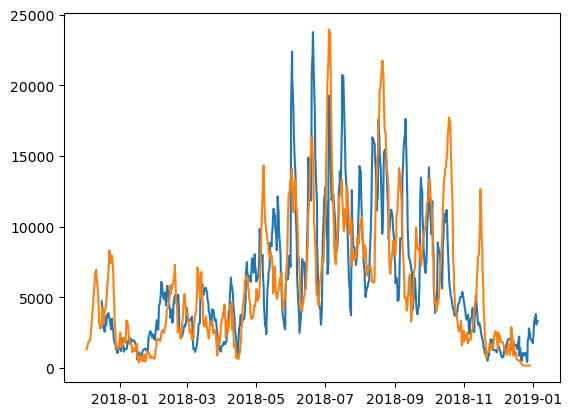

In [40]:
PRtovs2018_ros_sh = shift_time(PRtovs2018_ros,age_2018['forpr_ros3'][4][365:750],datelist_vs[365:750],base_adm[0],factor_adm[0])
PRtovs2018_rosb_sh = shift_time(PRtovs2018_rosb,age_2018['backvs_ros3'][4][365:750],datelist_vs[365:750],-base_adm[0],-factor_adm[0])

PRtovs2018_ros_m,PRtovs2018_rosb_m,c,PRtovs2018_ros_avg = merge(PRtovs2018_ros_sh,PRtovs2018_rosb_sh)
print(c)

plt.plot(PRtovs2018_ros_m.Transport)
plt.plot(PRtovs2018_rosb_m.Transport)

#### Now do this for 2019

In [41]:
PRtovs2019_rosl = sectransp_2018['forpr_ros3'][4][750:1110]
PRtovs2019_rosbl = sectransp_2018['backvs_ros3'][4][750:1110]

PRtovs2019_ros = pd.Series(PRtovs2019_rosl,index=datelist_vs[750:1110])
PRtovs2019_rosb = pd.Series(PRtovs2019_rosbl,index=datelist_vs[750:1110])

In [42]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs2019_ros,age_2018['forpr_ros3'][4][750:1110],datelist_vs[750:1110],base,factor)
        dfr2 = shift_time(PRtovs2019_rosb,age_2018['backvs_ros3'][4][750:1110],datelist_vs[750:1110],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.57:
            print (base, factor, corr_arr[i, j])

-1.0 0.30000000000000115 0.6075211384337887
-0.95 0.30000000000000115 0.5934285748119174
-0.8999999999999999 0.30000000000000115 0.5876971535653234
-0.8499999999999999 0.2500000000000011 0.5715248251737987
-0.8499999999999999 0.30000000000000115 0.5889254336422471
-0.7999999999999998 0.2500000000000011 0.5838706505899164
-0.7999999999999998 0.30000000000000115 0.5860876576449531
-0.7499999999999998 0.2500000000000011 0.5881843768809775
-0.7499999999999998 0.30000000000000115 0.5763112030109387
-0.6999999999999997 0.2500000000000011 0.5905018505811092
-0.6999999999999997 0.30000000000000115 0.5745533726522075
-0.6499999999999997 0.2500000000000011 0.5917824028232308
-0.6499999999999997 0.30000000000000115 0.5776125998124596
-0.5999999999999996 0.2500000000000011 0.5925020515621047
-0.5999999999999996 0.30000000000000115 0.5803866724311336
-0.5499999999999996 0.2500000000000011 0.5914653219695614
-0.49999999999999956 0.2500000000000011 0.60028901117714
-0.4499999999999995 0.2500000000000

In [43]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-1.] [0.3]


0.6075211384337887


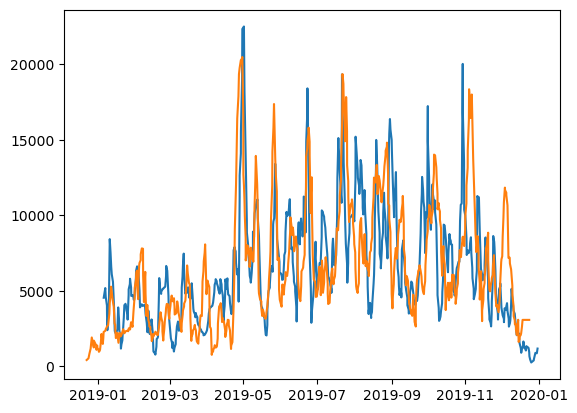

In [44]:
PRtovs2019_ros_sh = shift_time(PRtovs2019_ros,age_2018['forpr_ros3'][4][750:1110],datelist_vs[750:1110],base_adm[0],factor_adm[0])
PRtovs2019_rosb_sh = shift_time(PRtovs2019_rosb,age_2018['backvs_ros3'][4][750:1110],datelist_vs[750:1110],-base_adm[0],-factor_adm[0])

PRtovs2019_ros_m,PRtovs2019_rosb_m,c,PRtovs2019_ros_avg = merge(PRtovs2019_ros_sh,PRtovs2019_rosb_sh)
print(c)

plt.plot(PRtovs2019_ros_m.Transport)
plt.plot(PRtovs2019_rosb_m.Transport)

#### Now this for 2020

In [45]:
PRtovs2020_rosl = sectransp_2018['forpr_ros3'][4][1110:1460]
PRtovs2020_rosbl = sectransp_2018['backvs_ros3'][4][1110:1460]

PRtovs2020_ros = pd.Series(PRtovs2020_rosl,index=datelist_vs[1110:1460])
PRtovs2020_rosb = pd.Series(PRtovs2020_rosbl,index=datelist_vs[1110:1460])

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs2020_ros,age_2018['forpr_ros3'][4][1110:1460],datelist_vs[1110:1460],base,factor)
        dfr2 = shift_time(PRtovs2020_rosb,age_2018['backvs_ros3'][4][1110:1460],datelist_vs[1110:1460],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.57:
            print (base, factor, corr_arr[i, j])
            
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

-1.0 0.15000000000000102 0.5777372008991812
-1.0 0.20000000000000107 0.7235128021885254
-1.0 0.2500000000000011 0.8179089506000464
-1.0 0.30000000000000115 0.7909405145146315
-1.0 0.3500000000000012 0.6719771739841168
-0.95 0.15000000000000102 0.5777823554010787
-0.95 0.20000000000000107 0.7375340915786694
-0.95 0.2500000000000011 0.8184372337250299
-0.95 0.30000000000000115 0.7864914657032738
-0.95 0.3500000000000012 0.6734633970430354
-0.8999999999999999 0.15000000000000102 0.5787356048095568
-0.8999999999999999 0.20000000000000107 0.7451338022394541
-0.8999999999999999 0.2500000000000011 0.8202240288090273
-0.8999999999999999 0.30000000000000115 0.7826189888483195
-0.8999999999999999 0.3500000000000012 0.6681729009386236
-0.8499999999999999 0.15000000000000102 0.5942466286999506
-0.8499999999999999 0.20000000000000107 0.7522822875244591
-0.8499999999999999 0.2500000000000011 0.819421588915242
-0.8499999999999999 0.30000000000000115 0.7776565147506596
-0.8499999999999999 0.3500000000

0.8240852710771296


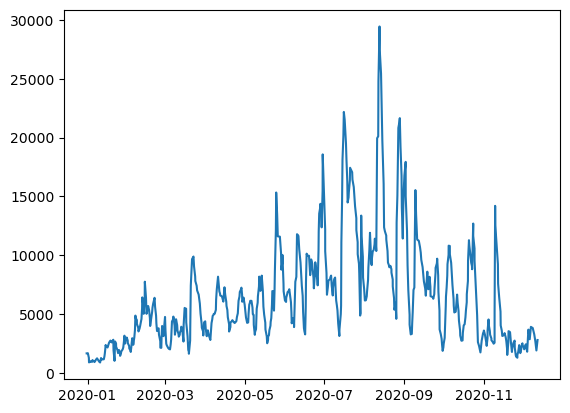

In [46]:
PRtovs2020_ros_sh = shift_time(PRtovs2020_ros,age_2018['forpr_ros3'][4][1110:1460],datelist_vs[1110:1460],base_adm[0],factor_adm[0])
PRtovs2020_rosb_sh = shift_time(PRtovs2020_rosb,age_2018['backvs_ros3'][4][1110:1460],datelist_vs[1110:1460],-base_adm[0],-factor_adm[0])

PRtovs2020_ros_m,PRtovs2020_rosb_m,c,PRtovs2020_ros_avg = merge(PRtovs2020_ros_sh,PRtovs2020_rosb_sh)
print(c)

plt.plot(PRtovs2020_ros_m.Transport)

#### Now for 2021

In [47]:
PRtovs2021_rosl = sectransp_2018['forpr_ros3'][4][1460:]
PRtovs2021_rosbl = sectransp_2018['backvs_ros3'][4][1460:]

PRtovs2021_ros = pd.Series(PRtovs2021_rosl,index=datelist_vs[1460:])
PRtovs2021_rosb = pd.Series(PRtovs2021_rosbl,index=datelist_vs[1460:])

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs2021_ros,age_2018['forpr_ros3'][4][1460:],datelist_vs[1460:],base,factor)
        dfr2 = shift_time(PRtovs2021_rosb,age_2018['backvs_ros3'][4][1460:],datelist_vs[1460:],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.57:
            print (base, factor, corr_arr[i, j])
            
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

-1.0 0.15000000000000102 0.5746431334328468
-1.0 0.20000000000000107 0.6588634608325542
-1.0 0.2500000000000011 0.6987159890164342
-1.0 0.30000000000000115 0.6927351707953536
-1.0 0.3500000000000012 0.6280027152299005
-0.95 0.15000000000000102 0.580675311420146
-0.95 0.20000000000000107 0.6561114586429423
-0.95 0.2500000000000011 0.7013669316289
-0.95 0.30000000000000115 0.6877956954337255
-0.95 0.3500000000000012 0.6318229646626421
-0.8999999999999999 0.15000000000000102 0.5966212787720768
-0.8999999999999999 0.20000000000000107 0.653761961170511
-0.8999999999999999 0.2500000000000011 0.7041142268384983
-0.8999999999999999 0.30000000000000115 0.6802387962689193
-0.8999999999999999 0.3500000000000012 0.6402407795152583
-0.8499999999999999 0.15000000000000102 0.6068629793317425
-0.8499999999999999 0.20000000000000107 0.6660516386117893
-0.8499999999999999 0.2500000000000011 0.695207334028077
-0.8499999999999999 0.30000000000000115 0.6829702559701336
-0.8499999999999999 0.350000000000001

0.7089597479508084


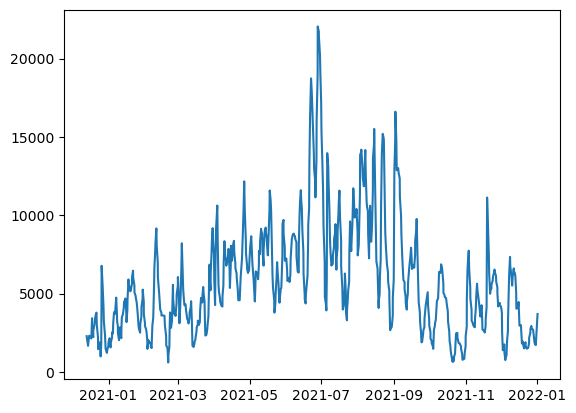

In [48]:
PRtovs2021_ros_sh = shift_time(PRtovs2021_ros,age_2018['forpr_ros3'][4][1460:],datelist_vs[1460:],base_adm[0],factor_adm[0])
PRtovs2021_rosb_sh = shift_time(PRtovs2021_rosb,age_2018['backvs_ros3'][4][1460:],datelist_vs[1460:],-base_adm[0],-factor_adm[0])

PRtovs2021_ros_m,PRtovs2021_rosb_m,c,PRtovs2021_ros_avg = merge(PRtovs2021_ros_sh,PRtovs2021_rosb_sh)
print(c)

plt.plot(PRtovs2021_ros_m.Transport)

#### Flow south through Rosario

In [49]:
#Separate for each year
## 2017
rostosouth_2017 = PRtovs2017_ros_avg + PRtoadm2017_ros_avg
date2017_rossh = list(rostosouth_2017.dropna().index)

mask = np.isin(datelist_dens,date2017_rossh)
densdiff_ros2017 = dens_diff_ros[mask]
date_dens_2017sh = np.array(datelist_dens)[mask]

corr_rostosouth2017,p = stats.spearmanr(densdiff_ros2017,rostosouth_2017.dropna())
print('2017:',corr_rostosouth2017)

## 2018
rostosouth_2018 = PRtovs2018_ros_avg + PRtoadm2018_ros_avg
date2018_rossh = list(rostosouth_2018.dropna().index)

mask = np.isin(datelist_dens,date2018_rossh)
densdiff_ros2018 = dens_diff_ros[mask]
date_dens_2018sh = np.array(datelist_dens)[mask]

corr_rostosouth2018,p = stats.spearmanr(densdiff_ros2018,rostosouth_2018.dropna())
print('2018:',corr_rostosouth2018)

##2019
rostosouth_2019 = PRtovs2019_ros_avg.dropna() + PRtoadm2019_ros_avg.dropna()
date2019_rossh = list(rostosouth_2019.dropna().index)

mask = np.isin(datelist_dens,date2019_rossh)
densdiff_ros2019 = dens_diff_ros[mask]
date_dens_2019sh = np.array(datelist_dens)[mask]

corr_rostosouth2019,p = stats.spearmanr(densdiff_ros2019,rostosouth_2019.dropna())
print('2019:',corr_rostosouth2019)

##2020
rostosouth_2020 = PRtovs2020_ros_avg.dropna() + PRtoadm2020_ros_avg.dropna()
date2020_rossh = list(rostosouth_2020.dropna().index)

mask = np.isin(datelist_dens,date2020_rossh)
densdiff_ros2020 = dens_diff_ros[mask]
date_dens_2020sh = np.array(datelist_dens)[mask]

corr_rostosouth2020,p = stats.spearmanr(densdiff_ros2020,rostosouth_2020.dropna())
print('2020:',corr_rostosouth2020)

##2021
rostosouth_2021 = PRtovs2021_ros_avg.dropna() + PRtoadm2021_ros_avg.dropna()
date2021_rossh = list(rostosouth_2021.dropna().index)

mask = np.isin(datelist_dens,date2021_rossh)
densdiff_ros2021 = dens_diff_ros[mask]
date_dens_2021sh = np.array(datelist_dens)[mask]

corr_rostosouth2021,p = stats.spearmanr(densdiff_ros2021,rostosouth_2021.dropna())
print('2021:',corr_rostosouth2021)


2017: 0.8026360800109054
2018: 0.8292558573214036
2019: 0.6999855275351025
2020: 0.7782638846760945
2021: 0.7886338537636968


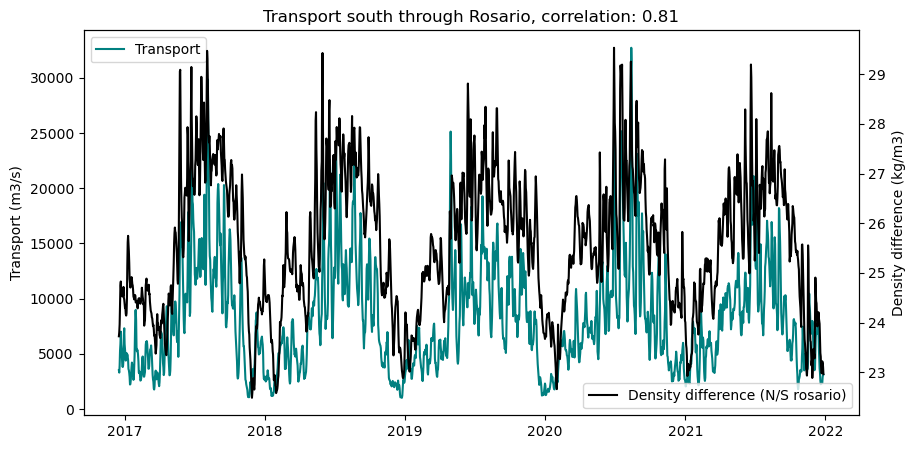

In [50]:
rostosouth = PRtovs_ros_avg + PRtoadm_ros_avg
date_rossh = list(rostosouth.dropna().index)

mask = np.isin(datelist_dens,date_rossh)
densdiff_ros = dens_diff_ros[mask]
# densdiff_ros2 = dens_diff_rosVS[mask]
date_dens_sh = np.array(datelist_dens)[mask]

corr_rostosouth,p = stats.spearmanr(densdiff_ros,rostosouth.dropna())

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(rostosouth.dropna(),color='teal',label='Transport')
ax2=ax.twinx()
ax2.plot(date_dens_sh,densdiff_ros,color='k',label='Density difference (N/S rosario)')
ax.set_title(f'Transport south through Rosario, correlation: {np.round(corr_rostosouth,2)}')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
ax.legend(loc=2)
ax2.legend()

Text(0.5, 1.0, 'corr = -0.111')

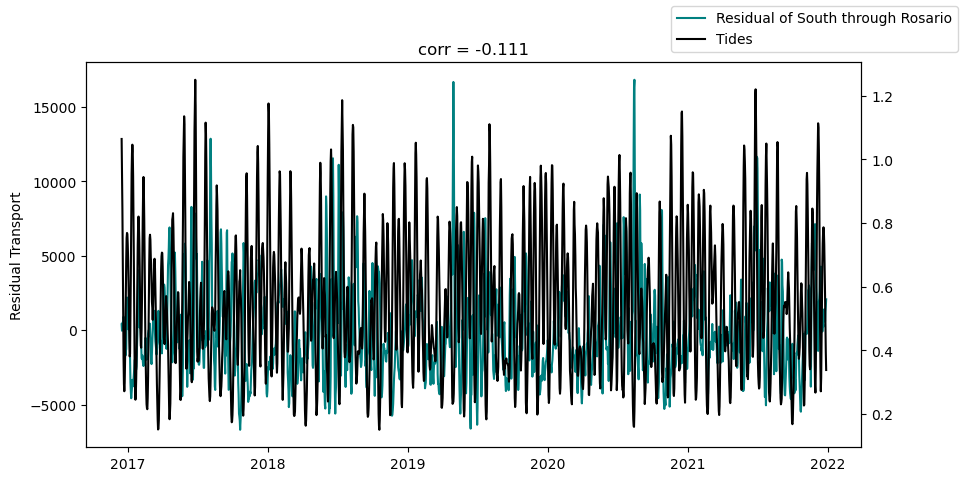

In [51]:
slope,intercept = np.polyfit(densdiff_ros,rostosouth.dropna(),1)
ddline = slope*densdiff_ros+intercept
res = rostosouth.dropna() - ddline

mask = np.isin(datelist_tides,date_rossh)
date_tides_sh = np.array(datelist_tides)[mask]
tides_sh = tides[mask]

corr,p = stats.spearmanr(tides_sh,res)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res,color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_tides_sh,tides_sh,color='k',label='Tides')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr,3)}')

Text(0.5, 1.0, 'corr = -0.206')

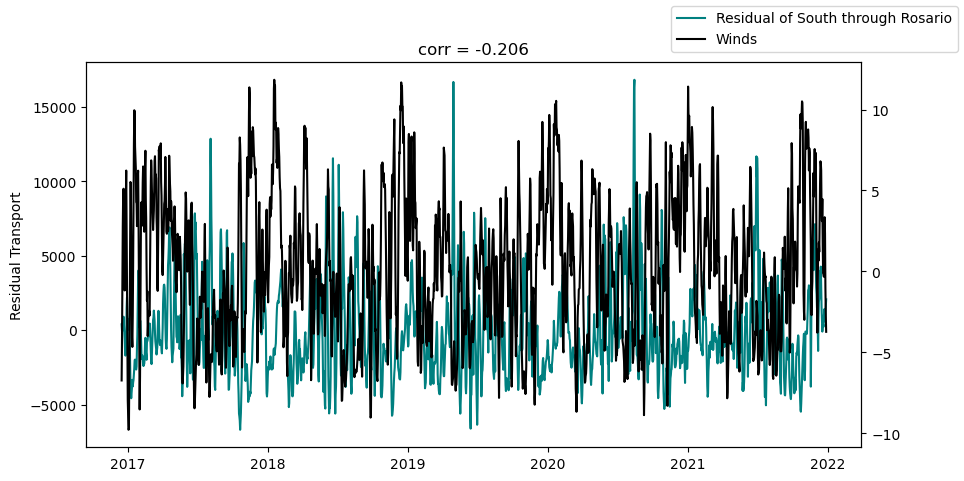

In [52]:
mask = np.isin(datelist_winds,date_rossh)
date_winds_sh = np.array(datelist_winds)[mask]
winds_sh = y_mean4[mask]

corr,p = stats.spearmanr(winds_sh,res)
corr

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res,color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_winds_sh,winds_sh,color='k',label='Winds')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr,3)}')

In [53]:
# Calculate correlations separately
idx = 379
idx_z1 = 20
idx_z2 = 110
idx_z3 = 230
idx_z4 = 379

ros2south_2018 = rostosouth_2018.dropna()
ros2south_2019 = rostosouth_2019.dropna()
winds_2018 = winds_sh[0:idx]
winds_2019 = winds_sh[idx:]
mask = np.isin(datelist_dens,date2018_rossh)
densdiff_ros_2018 = dens_diff_ros[mask]
densdiff_ros_2019 = densdiff_ros[idx:]
tides_2018 = tides_sh[0:idx]
tides_2019 = tides_sh[idx:750]
res_2018 = res[0:idx]
res_2019 = res[idx:750]
date_2018 = date_tides_sh[0:idx]
date_2019 = date_tides_sh[idx:750]

#Separate ddline for each year

##2017

mask = np.isin(datelist_dens,date2017_rossh)
densdiff_ros2017 = dens_diff_ros[mask]
slope,intercept = np.polyfit(densdiff_ros2017,rostosouth_2017.dropna(),1)
ddline2017 = slope*densdiff_ros2017+intercept
res2017 = rostosouth_2017.dropna() - ddline2017
print(slope,intercept)

mask = np.isin(datelist_tides,date2017_rossh)
date_tides_2017sh = np.array(datelist_tides)[mask]
tides2017 = tides[mask]

mask = np.isin(datelist_winds,date2017_rossh)
date_winds_2017sh = np.array(datelist_winds)[mask]
winds2017 = y_mean4[mask]

##2018
slope,intercept = np.polyfit(densdiff_ros2018,rostosouth_2018.dropna(),1)
ddline2018 = slope*densdiff_ros2018+intercept
res2018 = rostosouth_2018.dropna() - ddline2018
print(slope,intercept)

mask = np.isin(datelist_tides,date2018_rossh)
date_tides_2018sh = np.array(datelist_tides)[mask]
tides2018 = tides[mask]

mask = np.isin(datelist_winds,date2018_rossh)
date_winds_2018sh = np.array(datelist_winds)[mask]
winds2018 = y_mean4[mask]

## 2019
slope,intercept = np.polyfit(densdiff_ros2019,rostosouth_2019.dropna(),1)
ddline2019 = slope*densdiff_ros2019+intercept
res2019 = rostosouth_2019.dropna() - ddline2019

mask = np.isin(datelist_tides,date2019_rossh)
date_tides_2019sh = np.array(datelist_tides)[mask]
tides2019 = tides[mask]

mask = np.isin(datelist_winds,date2019_rossh)
date_winds_2019sh = np.array(datelist_winds)[mask]
winds2019 = y_mean4[mask]

##2020
mask = np.isin(datelist_dens,date2020_rossh)
densdiff_ros2020 = dens_diff_ros[mask]
slope,intercept = np.polyfit(densdiff_ros2020,rostosouth_2020.dropna()[0:379],1)
ddline2020 = slope*densdiff_ros2020+intercept
res2020 = rostosouth_2020.dropna()[0:379] - ddline2020
print(slope,intercept)

mask = np.isin(datelist_tides,date2020_rossh)
date_tides_2020sh = np.array(datelist_tides)[mask]
tides2020 = tides[mask]

mask = np.isin(datelist_winds,date2020_rossh)
date_winds_2020sh = np.array(datelist_winds)[mask]
winds2020 = y_mean4[mask]

##2021
mask = np.isin(datelist_dens,date2021_rossh)
densdiff_ros2021 = dens_diff_ros[mask]
slope,intercept = np.polyfit(densdiff_ros2021,rostosouth_2021.dropna()[0:379],1)
ddline2021 = slope*densdiff_ros2021+intercept
res2021 = rostosouth_2021.dropna()[0:379] - ddline2021
print(slope,intercept)

mask = np.isin(datelist_tides,date2021_rossh)
date_tides_2021sh = np.array(datelist_tides)[mask]
tides2021 = tides[mask]

mask = np.isin(datelist_winds,date2021_rossh)
date_winds_2021sh = np.array(datelist_winds)[mask]
winds2021 = y_mean4[mask]


2805.3560271493034 -63463.627032534736
2750.351224256408 -62426.847692377734
3301.917881632561 -76306.85424308112
2262.0200527199145 -49733.507581236925


(2262.0200527199145, -49733.507581236925)

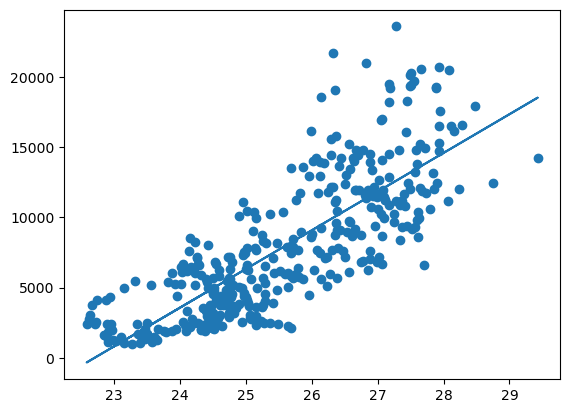

In [54]:
plt.scatter(densdiff_ros2018,rostosouth_2018.dropna())
plt.plot(densdiff_ros2018,ddline2018)
slope,intercept

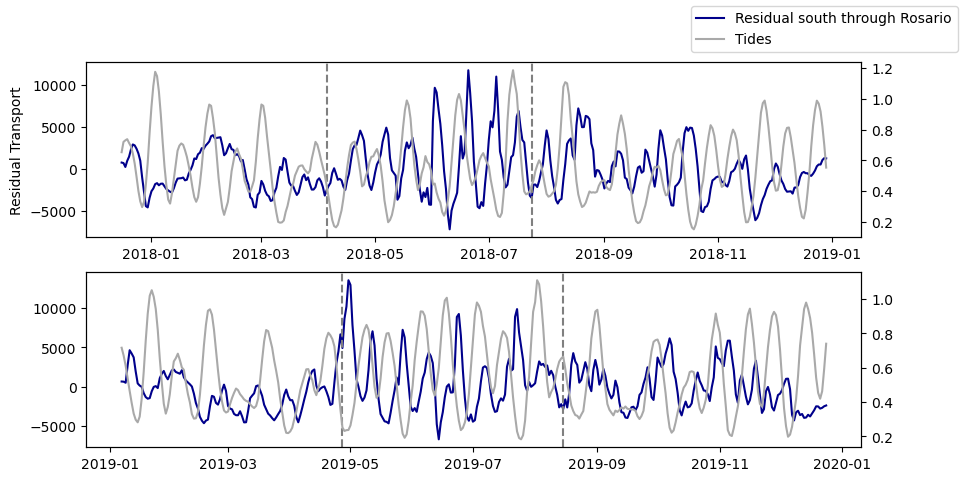

In [55]:
fig,ax = plt.subplots(2,1,figsize=(10,5))
ax2 = ax[0].twinx()
ax2.plot(date_tides_2018sh,tides2018,color='darkgrey',label='Tides')
ax[0].set_ylabel('Residual Transport')
# ax.plot(rostosouth.dropna(),label='Transport south through Rosario')
ax[0].plot(res2018,label='Residual south through Rosario',color='darkblue')
ax[0].axvline(date_tides_sh[110+365],ls='--',color='grey')
ax[0].axvline(date_tides_sh[220+365],ls='--',color='grey')
# ax[0].axvline(date_tides_sh[300+365],ls='--',color='grey')
ax3 = ax[1].twinx()
ax3.plot(date_tides_2019sh,tides2019,color='darkgrey')
ax[1].plot(res2019,color='darkblue')
ax[1].axvline(date_tides_2019sh[110],ls='--',color='grey')
ax[1].axvline(date_tides_2019sh[220],ls='--',color='grey')
# ax[1].axvline(date_2019[300],ls='--',color='grey')
fig.legend()

In [56]:
print('Correlations of residual rosS and tides')
corr,p = stats.spearmanr(tides2017[110:240],res2017[110:240])
print('2017:',corr)
corr,p = stats.spearmanr(tides2018[110:240],res2018[110:240])
print('2018:',corr)
corr,p = stats.spearmanr(tides2019[110:240],res2019[110:240])
print('2019:',corr)
corr,p = stats.spearmanr(tides2020[110:240],res2020[110:240])
print('2020:',corr)
corr,p = stats.spearmanr(tides2021[110:240],res2021[110:240])
print('2021:',corr)

Correlations of residual rosS and tides
2017: -0.14586297778202623
2018: -0.06299963129361318
2019: -0.3893676002676535
2020: -0.21818951508282236
2021: -0.20217946441983367


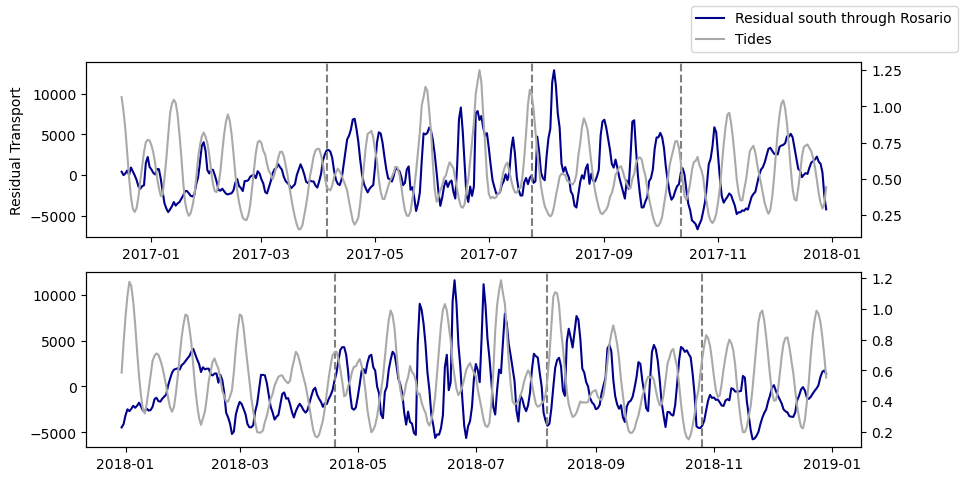

In [57]:
fig,ax = plt.subplots(2,1,figsize=(10,5))
ax2 = ax[0].twinx()
ax2.plot(date_2018,tides_2018,color='darkgrey',label='Tides')
ax[0].set_ylabel('Residual Transport')
# ax.plot(rostosouth.dropna(),label='Transport south through Rosario')
ax[0].plot(res_2018,label='Residual south through Rosario',color='darkblue')
ax[0].axvline(date_tides_sh[110],ls='--',color='grey')
ax[0].axvline(date_tides_sh[220],ls='--',color='grey')
ax[0].axvline(date_tides_sh[300],ls='--',color='grey')
ax3 = ax[1].twinx()
ax3.plot(date_2019[:365],tides_2019[:365],color='darkgrey')
ax[1].plot(res_2019[:365],color='darkblue')
ax[1].axvline(date_2019[110],ls='--',color='grey')
ax[1].axvline(date_2019[220],ls='--',color='grey')
ax[1].axvline(date_2019[300],ls='--',color='grey')
fig.legend()

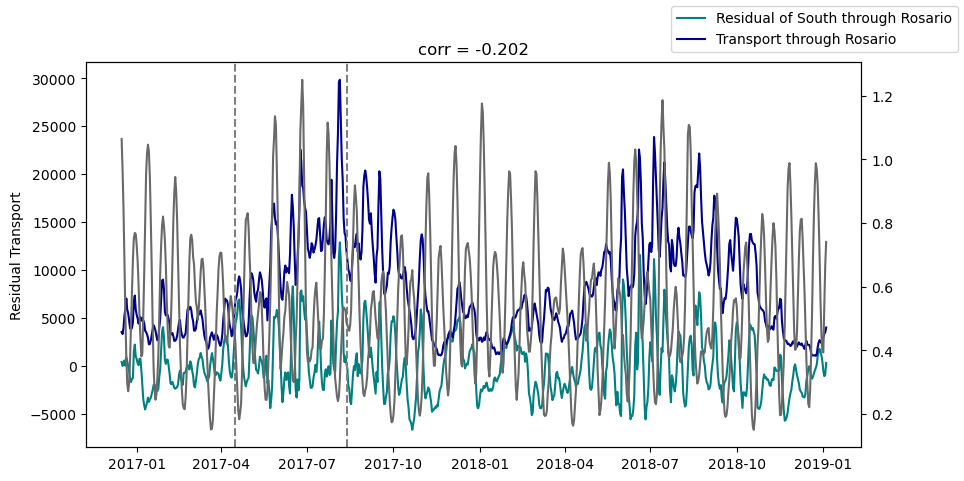

In [58]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res[:750],color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_tides_sh[:750],tides_sh[:750],color='dimgrey')
ax.plot(rostosouth.dropna()[:750],color='darkblue',label='Transport through Rosario')
# ax.plot(harotosouth.dropna(),color='sienna',label='Transport through Haro')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr,3)}')
ax.axvline(date_tides_sh[120],ls='--',color='grey')
ax.axvline(date_tides_sh[240],ls='--',color='grey')


### River Flow

In [59]:
# Import data and take mean

FR_data = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/FR_discharge_16-22.csv')
FR_4mean = FR_data['Discharge (m3/s)'].rolling(window=4,center=True).mean()

date = dt.datetime(2016,1,1)
enddate = dt.datetime(2022,12,31)

dates = []
datelist_FR = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_FR.append(date)
    date += dt.timedelta(days=1)
    
print(len(datelist_FR))
print(len(FR_4mean))

2557
2557


In [60]:
# Add all other runoff from climatology

rivers = xr.open_dataset('/data/SalishSeaCast/rivers-climatology/watershed_climatologies/Salish_allrivers_daily.nc')
clim = np.zeros(365)

for river in rivers.data_vars:
    clim += rivers[river][0:]
    
clim -= rivers['fraser']

date = dt.datetime(2020,1,1)
enddate = dt.datetime(2020,12,31)
dates = []
datelist_2020 = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_2020.append(date)
    date += dt.timedelta(days=1)

idx_leap = datelist_2020.index(dt.datetime(2020,2,29))

clim2020 = np.insert(clim,idx_leap,(clim[58]+clim[59])/2)

clim1718 = np.append(clim,clim)
clim1719 = np.append(clim1718,clim)
clim1720 = np.append(clim1719,clim2020)
clim1721 = np.append(clim1720,clim)
clim1722 = np.append(clim1721,clim)
len(clim1722)

date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)
datelist_yrs = []
dates = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_yrs.append(date)
    date += dt.timedelta(days=1)
       
df_FR_4mean = pd.DataFrame(FR_4mean.values,index=datelist_FR)
df_clim = pd.DataFrame(clim1722,index=datelist_yrs)

runoff = df_FR_4mean.add(df_clim, fill_value=0)

In [61]:
mask = np.isin(datelist_FR,date_rossh)
runoff_ros = runoff[mask]
FR_4mean_ros = FR_4mean[mask]

In [62]:
print('Correlations of 2017 with line of best fit through 18-21')
print(stats.spearmanr(tides_sh[:110],res[:110])[0])
print(stats.spearmanr(tides_sh[110:240],res[110:240])[0])
print(stats.spearmanr(tides_sh[240:379],res[240:379])[0])
print(stats.spearmanr(tides_sh[0:379],res[0:379])[0])

print('Correlations of 2018 with line of best fit through 18-21')
print(stats.spearmanr(tides_sh[365:110+365],res[365:110+365])[0])
print(stats.spearmanr(tides_sh[110+365:240+365],res[110+365:240+365])[0])
print(stats.spearmanr(tides_sh[240+365:379+365],res[240+365:379+365])[0])
print(stats.spearmanr(tides_sh[0+365:379+365],res[0+365:379+365])[0])

Correlations of 2017 with line of best fit through 18-21
-0.024854045037531275
-0.14166791844760954
-0.30805219178694304
-0.18000961065813167
Correlations of 2018 with line of best fit through 18-21
-0.05479791718323829
-0.06676862991437818
-0.3077528039680057
-0.15967138602883638


Gets more negatively correlated later in the year

Text(0, 0.5, 'Fraser river flow (m3/s)')

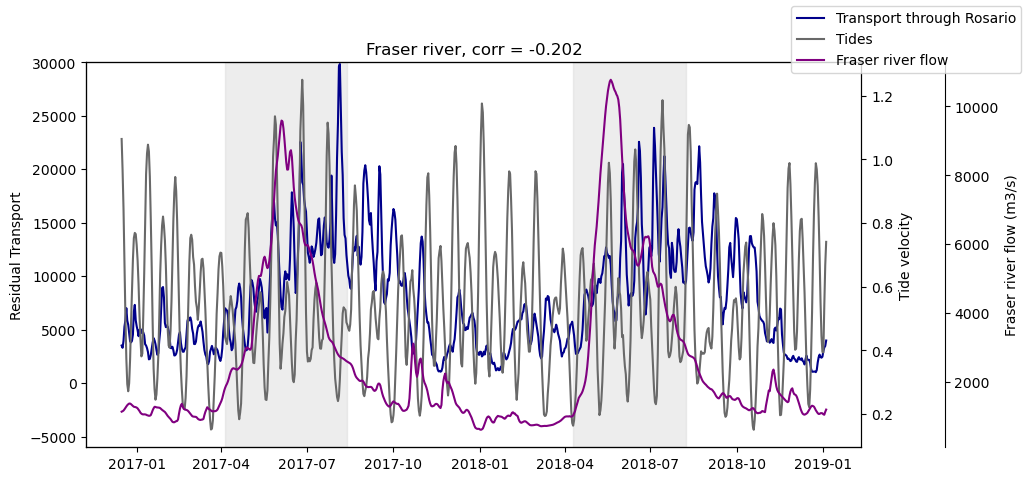

In [63]:
fig,ax = plt.subplots(figsize=(10,5))
ax2 = ax.twinx()
ax2.plot(date_tides_sh[:750],tides_sh[:750],color='dimgrey',label='Tides')
ax.plot(rostosouth.dropna()[:750],color='darkblue',label='Transport through Rosario')

ax.set_ylabel('Residual Transport')
ax.set_title(f'Fraser river, corr = {np.round(corr,3)}')
ax3 = ax.twinx()
ax3.plot(date_rossh[:750],FR_4mean_ros[:750],color='purple',label='Fraser river flow')

ax.set_ylim([-6000,30000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_tides_sh[110],x2=date_tides_sh[240],color='lightgrey', alpha=0.4)
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_tides_sh[480],x2=date_tides_sh[600],color='lightgrey', alpha=0.4)
ax3.spines['right'].set_position(('outward', 60))
fig.legend()
ax2.set_ylabel('Tide velocity')
ax3.set_ylabel('Fraser river flow (m3/s)')


## Flow to admiralty vs. to VicSill

0.7945141150733623


Text(0.5, 1.0, 'PR to adm, corr = 0.18')

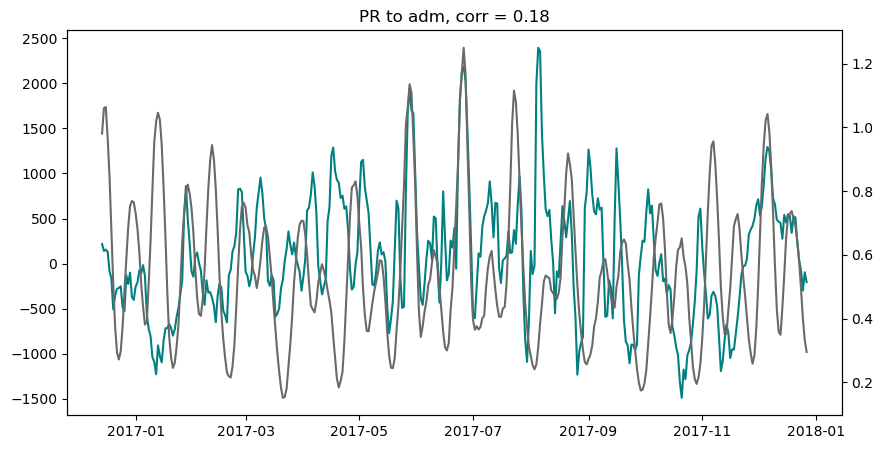

In [64]:
PRtoadm_ros_avg.dropna()
date_prtoadm = list(PRtoadm_ros_avg.dropna().index)

mask = np.isin(datelist_dens,date_prtoadm)
densdiff_prtoadm = dens_diff_ros[mask]

mask = np.isin(datelist_tides,date_prtoadm)
tides_prtoadm = tides[mask]

corr,p = stats.spearmanr(densdiff_prtoadm,PRtoadm_ros_avg.dropna())
print(corr)
slope,intercept = np.polyfit(densdiff_prtoadm,PRtoadm_ros_avg.dropna(),1)
res_prtoadm = PRtoadm_ros_avg.dropna() - (slope*densdiff_prtoadm+intercept)

corr,p = stats.spearmanr(tides_prtoadm,res_prtoadm)
# print(stats.spearmanr(tides_prtoadm[110:240],PRtoadm_ros_avg.dropna()[110:240])[0])
# print(stats.spearmanr(tides_prtoadm[:110],PRtoadm_ros_avg.dropna()[:110])[0])
# print(stats.spearmanr(tides_prtoadm[240:379],PRtoadm_ros_avg.dropna()[240:379])[0])

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_prtoadm[0:379],color='teal')
ax2 = ax.twinx()
ax2.plot(date_prtoadm[0:379],tides_prtoadm[0:379],color='dimgrey')
ax.set_title(f'PR to adm, corr = {np.round(corr,2)}')

0.7945141150733623


Text(0.5, 1.0, 'PR to adm, corr = 0.18')

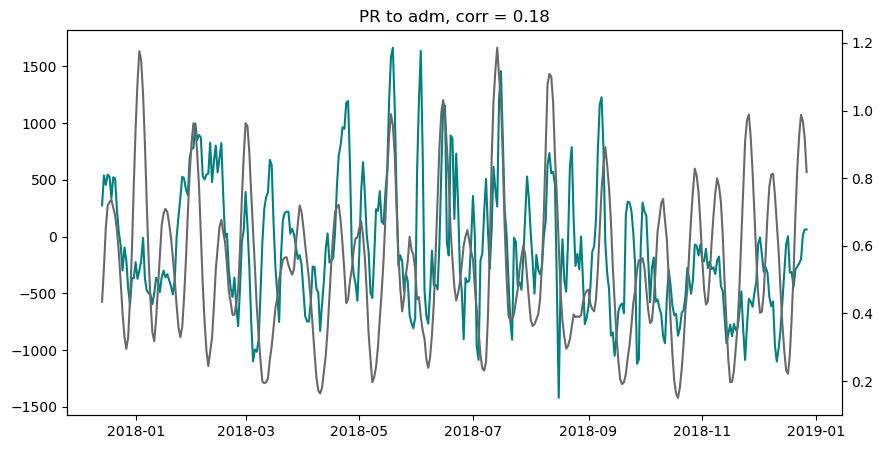

In [65]:
corr,p = stats.spearmanr(densdiff_prtoadm,PRtoadm_ros_avg.dropna())
print(corr)
slope,intercept = np.polyfit(densdiff_prtoadm,PRtoadm_ros_avg.dropna(),1)
res_prtoadm = PRtoadm_ros_avg.dropna() - (slope*densdiff_prtoadm+intercept)

corr,p = stats.spearmanr(tides_prtoadm,res_prtoadm)
# print(stats.spearmanr(tides_prtoadm[110:240],PRtoadm_ros_avg.dropna()[110:240])[0])
# print(stats.spearmanr(tides_prtoadm[:110],PRtoadm_ros_avg.dropna()[:110])[0])
# print(stats.spearmanr(tides_prtoadm[240:379],PRtoadm_ros_avg.dropna()[240:379])[0])

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_prtoadm[0+365:379+365],color='teal')
ax2 = ax.twinx()
ax2.plot(date_prtoadm[0+365:379+365],tides_prtoadm[0+365:379+365],color='dimgrey')
ax.set_title(f'PR to adm, corr = {np.round(corr,2)}')

0.7807015815273115
Correlations of different times (best fit line 18-21)
-0.1453357405945588
0.13130590339892667
0.09254108153190722
-0.3085347870771705


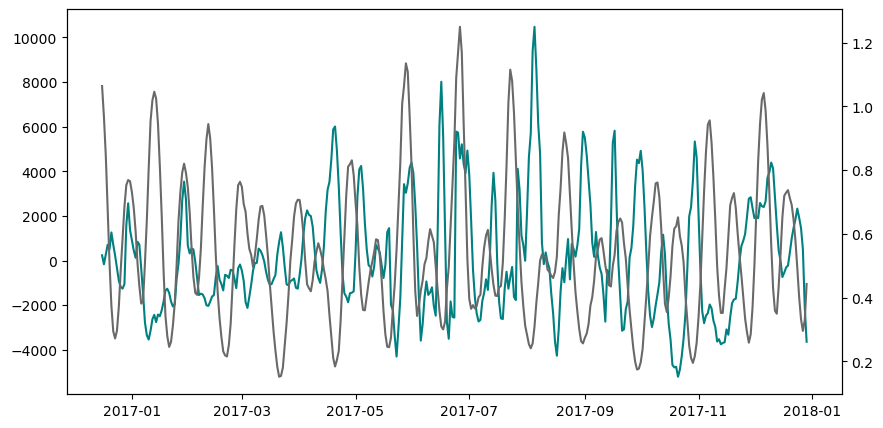

In [66]:
date_prtovs = list(PRtovs_ros_avg.dropna().index)

mask = np.isin(datelist_dens,date_prtovs)
densdiff_prtovs = dens_diff_ros[mask]

mask = np.isin(datelist_tides,date_prtovs)
tides_prtovs = tides[mask]

corr,p = stats.spearmanr(densdiff_prtovs,PRtovs_ros_avg.dropna())
print(corr)
slope,intercept = np.polyfit(densdiff_prtovs,PRtovs_ros_avg.dropna(),1)
res_prtovs = PRtovs_ros_avg.dropna() - (slope*densdiff_prtovs+intercept)

print('Correlations of different times (best fit line 18-21)')
print(stats.spearmanr(tides_prtovs,PRtovs_ros_avg.dropna())[0])
print(stats.spearmanr(tides_prtovs[110:240],PRtovs_ros_avg.dropna()[110:240])[0])
print(stats.spearmanr(tides_prtovs[:110],PRtovs_ros_avg.dropna()[:110])[0])
print(stats.spearmanr(tides_prtovs[240:379],PRtovs_ros_avg.dropna()[240:379])[0])

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_prtovs[0:379],color='teal')
ax2 = ax.twinx()
ax2.plot(date_prtovs[0:379],tides_prtovs[0:379],color='dimgrey')

0.7900418470307128
Correlations of different times (best fit line separate for each year) - PR to vs 2018
-0.24213587038994638
-0.22121563861311777
-0.05872912111444222
-0.39950691020209733


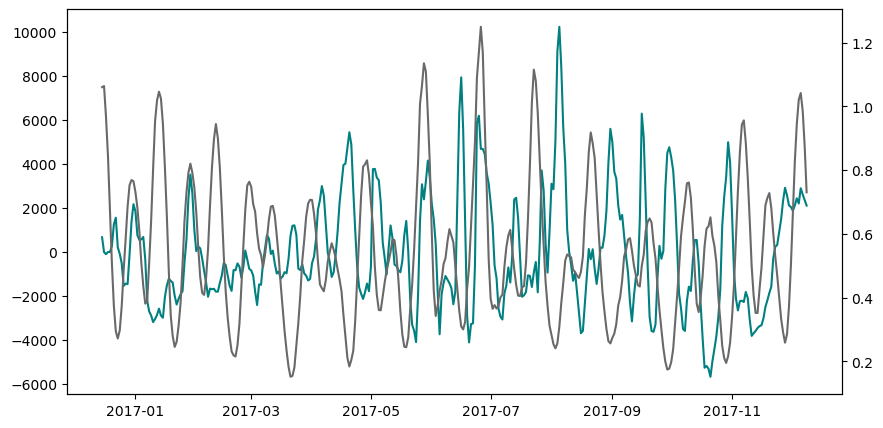

In [67]:
date_prtovs2017 = list(PRtovs2017_ros_avg.dropna().index)

mask = np.isin(datelist_dens,date_prtovs2017)
densdiff_prtovs2017 = dens_diff_ros[mask]

mask = np.isin(datelist_tides,date_prtovs2017)
tides_prtovs2017 = tides[mask]

corr,p = stats.spearmanr(densdiff_prtovs2017,PRtovs2017_ros_avg.dropna())
print(corr)
slope,intercept = np.polyfit(densdiff_prtovs2017,PRtovs2017_ros_avg.dropna(),1)
res_prtovs2017 = PRtovs2017_ros_avg.dropna() - (slope*densdiff_prtovs2017+intercept)

print('Correlations of different times (best fit line separate for each year) - PR to vs 2018')
print(stats.spearmanr(tides_prtovs2017,res_prtovs2017)[0])
print(stats.spearmanr(tides_prtovs2017[110:240],res_prtovs2017[110:240])[0])
print(stats.spearmanr(tides_prtovs2017[:110],res_prtovs2017[:110])[0])
print(stats.spearmanr(tides_prtovs2017[240:379],res_prtovs2017[240:379])[0])

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_prtovs2017,color='teal')
ax2 = ax.twinx()
ax2.plot(date_prtovs2017[0:379],tides_prtovs2017[0:379],color='dimgrey')

0.7956335429603031
Correlations of different times (best fit line separate for each year) - PR to vs 2018
-0.18961034953258254
-0.16044190143249257
-0.07077519554583774
-0.30628267572277573


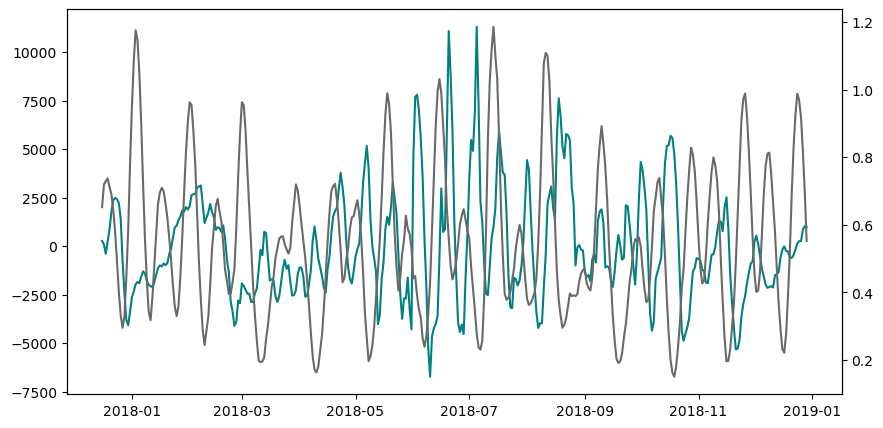

In [68]:
date_prtovs2018 = list(PRtovs2018_ros_avg.dropna().index)

mask = np.isin(datelist_dens,date_prtovs2018)
densdiff_prtovs2018 = dens_diff_ros[mask]

mask = np.isin(datelist_tides,date_prtovs2018)
tides_prtovs2018 = tides[mask]

corr,p = stats.spearmanr(densdiff_prtovs2018,PRtovs2018_ros_avg.dropna())
print(corr)
slope,intercept = np.polyfit(densdiff_prtovs2018,PRtovs2018_ros_avg.dropna(),1)
res_prtovs2018 = PRtovs2018_ros_avg.dropna() - (slope*densdiff_prtovs2018+intercept)

print('Correlations of different times (best fit line separate for each year) - PR to vs 2018')
print(stats.spearmanr(tides_prtovs2018,res_prtovs2018)[0])
print(stats.spearmanr(tides_prtovs2018[110:240],res_prtovs2018[110:240])[0])
print(stats.spearmanr(tides_prtovs2018[:110],res_prtovs2018[:110])[0])
print(stats.spearmanr(tides_prtovs2018[240:379],res_prtovs2018[240:379])[0])

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_prtovs2018,color='teal')
ax2 = ax.twinx()
ax2.plot(date_prtovs2018[0:379],tides_prtovs2018[0:379],color='dimgrey')

0.6634577820748417
Correlations of different times (best fit line separate for each year) - PR to vs 2019
-0.17728598584878896
-0.39316391047262694
-0.00843495705881027
-0.12587331159757803


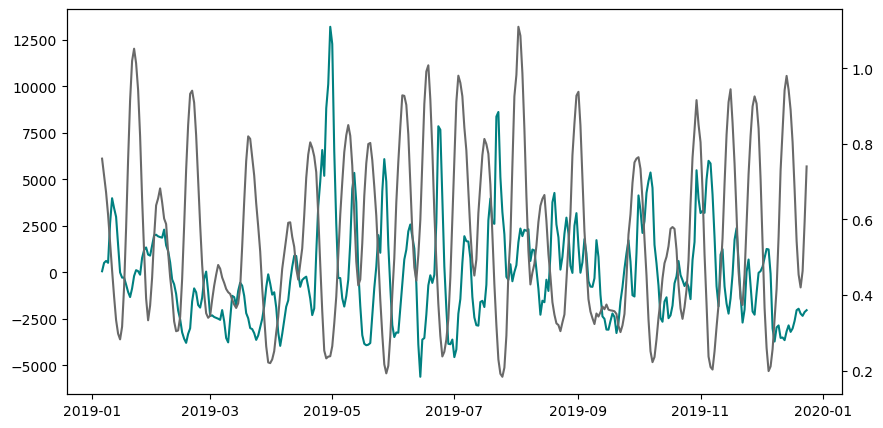

In [69]:
date_prtovs2019 = list(PRtovs2019_ros_avg.dropna().index)

mask = np.isin(datelist_dens,date_prtovs2019)
densdiff_prtovs2019 = dens_diff_ros[mask]

mask = np.isin(datelist_tides,date_prtovs2019)
tides_prtovs2019 = tides[mask]

corr,p = stats.spearmanr(densdiff_prtovs2019,PRtovs2019_ros_avg.dropna())
print(corr)
slope,intercept = np.polyfit(densdiff_prtovs2019,PRtovs2019_ros_avg.dropna(),1)
res_prtovs2019 = PRtovs2019_ros_avg.dropna() - (slope*densdiff_prtovs2019+intercept)

print('Correlations of different times (best fit line separate for each year) - PR to vs 2019')
print(stats.spearmanr(tides_prtovs2019,res_prtovs2019)[0])
print(stats.spearmanr(tides_prtovs2019[110:240],res_prtovs2019[110:240])[0])
print(stats.spearmanr(tides_prtovs2019[:110],res_prtovs2019[:110])[0])
print(stats.spearmanr(tides_prtovs2019[240:379],res_prtovs2019[240:379])[0])

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_prtovs2019,color='teal')
ax2 = ax.twinx()
ax2.plot(date_prtovs2019[0:379],tides_prtovs2019[0:379],color='dimgrey')

In [70]:
mask = np.isin(datelist_winds,date_prtovs2017)
winds_prtovs2017 = y_mean4[mask]
mask = np.isin(datelist_winds,date_prtovs2018)
winds_prtovs2018 = y_mean4[mask]
mask = np.isin(datelist_winds,date_prtovs2019)
winds_prtovs2019 = y_mean4[mask]

date_prtovs2020 = list(PRtovs2020_ros_avg.dropna().index)

mask = np.isin(datelist_dens,date_prtovs2020)
densdiff_prtovs2020 = dens_diff_ros[mask]

mask = np.isin(datelist_tides,date_prtovs2020)
tides_prtovs2020 = tides[mask]

mask = np.isin(datelist_winds,date_prtovs2020)
winds_prtovs2020 = y_mean4[mask]

corr,p = stats.spearmanr(densdiff_prtovs2020,PRtovs2020_ros_avg.dropna())
print(corr)

slope,intercept = np.polyfit(densdiff_prtovs2020,PRtovs2020_ros_avg.dropna(),1)
res_prtovs2020 = PRtovs2020_ros_avg.dropna() - (slope*densdiff_prtovs2020+intercept)

date_prtovs2021 = list(PRtovs2021_ros_avg.dropna().index)

mask = np.isin(datelist_dens,date_prtovs2021)
densdiff_prtovs2021 = dens_diff_ros[mask]

mask = np.isin(datelist_tides,date_prtovs2021)
tides_prtovs2021 = tides[mask]

mask = np.isin(datelist_winds,date_prtovs2021)
winds_prtovs2021 = y_mean4[mask]

corr,p = stats.spearmanr(densdiff_prtovs2021,PRtovs2021_ros_avg.dropna())
print(corr)
slope,intercept = np.polyfit(densdiff_prtovs2021,PRtovs2021_ros_avg.dropna(),1)
res_prtovs2021 = PRtovs2021_ros_avg.dropna() - (slope*densdiff_prtovs2021+intercept)

0.75553888280264
0.7541139568358011


Look @ this for adm in 2019 and see if that correlation is stronger than 2018

0.7706496176469086
Correlations of different times (best fit line separate for each year) - PR to adm 2018
0.0930439285185922
0.20448456212702618
0.08735658093456258
0.006591247798401298


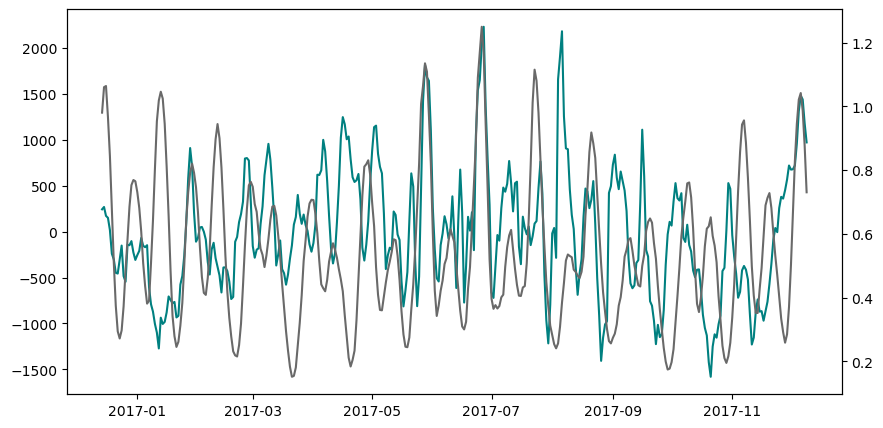

In [71]:
date_prtoadm2017 = list(PRtoadm2017_ros_avg.dropna().index)

mask = np.isin(datelist_dens,date_prtoadm2017)
densdiff_prtoadm2017 = dens_diff_ros[mask]

mask = np.isin(datelist_tides,date_prtoadm2017)
tides_prtoadm2017 = tides[mask]

corr,p = stats.spearmanr(densdiff_prtoadm2017,PRtoadm2017_ros_avg.dropna())
print(corr)
slope,intercept = np.polyfit(densdiff_prtoadm2017,PRtoadm2017_ros_avg.dropna(),1)
res_prtoadm2017 = PRtoadm2017_ros_avg.dropna() - (slope*densdiff_prtoadm2017+intercept)
print('Correlations of different times (best fit line separate for each year) - PR to adm 2018')
print(stats.spearmanr(tides_prtoadm2017,res_prtoadm2017)[0])
print(stats.spearmanr(tides_prtoadm2017[110:240],res_prtoadm2017[110:240])[0])
print(stats.spearmanr(tides_prtoadm2017[:110],res_prtoadm2017[:110])[0])
print(stats.spearmanr(tides_prtoadm2017[240:379],res_prtoadm2017[240:379])[0])

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_prtoadm2017,color='teal')
ax2 = ax.twinx()
ax2.plot(date_prtoadm2017[0:379],tides_prtoadm2017[0:379],color='dimgrey')

0.828432932767059
Correlations of different times (best fit line separate for each year) - PR to adm 2018
0.33405802163537945
0.5629163309617775
0.17896445235894778
0.2820099200142991


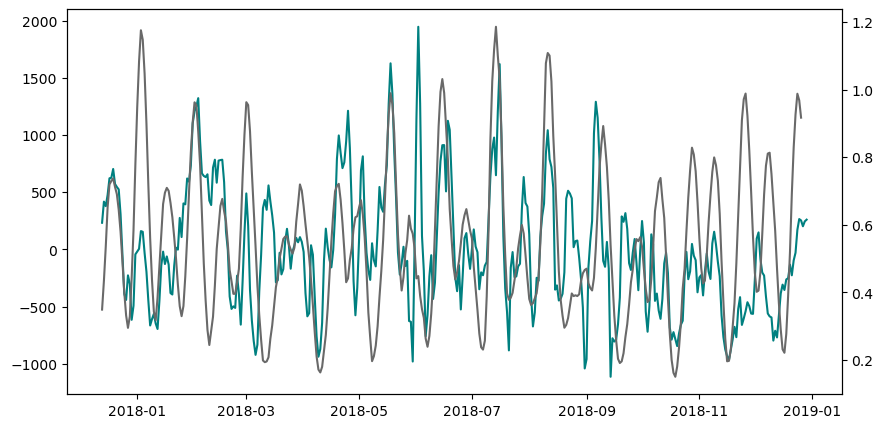

In [72]:
date_prtoadm2018 = list(PRtoadm2018_ros_avg.dropna().index)

mask = np.isin(datelist_dens,date_prtoadm2018)
densdiff_prtoadm2018 = dens_diff_ros[mask]

mask = np.isin(datelist_tides,date_prtoadm2018)
tides_prtoadm2018 = tides[mask]

corr,p = stats.spearmanr(densdiff_prtoadm2018,PRtoadm2018_ros_avg.dropna())
print(corr)
slope,intercept = np.polyfit(densdiff_prtoadm2018,PRtoadm2018_ros_avg.dropna(),1)
res_prtoadm2018 = PRtoadm2018_ros_avg.dropna() - (slope*densdiff_prtoadm2018+intercept)
print('Correlations of different times (best fit line separate for each year) - PR to adm 2018')
print(stats.spearmanr(tides_prtoadm2018,res_prtoadm2018)[0])
print(stats.spearmanr(tides_prtoadm2018[110:240],res_prtoadm2018[110:240])[0])
print(stats.spearmanr(tides_prtoadm2018[:110],res_prtoadm2018[:110])[0])
print(stats.spearmanr(tides_prtoadm2018[240:379],res_prtoadm2018[240:379])[0])

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_prtoadm2018,color='teal')
ax2 = ax.twinx()
ax2.plot(date_prtoadm2018[0:379],tides_prtoadm2018[0:379],color='dimgrey')

0.6884903733345659
Correlations of different times (best fit line separate for each year) - PR to vs 2019
-0.14534839570250335
-0.2173701675565691
-0.1691815251448279
-0.17077254245395837


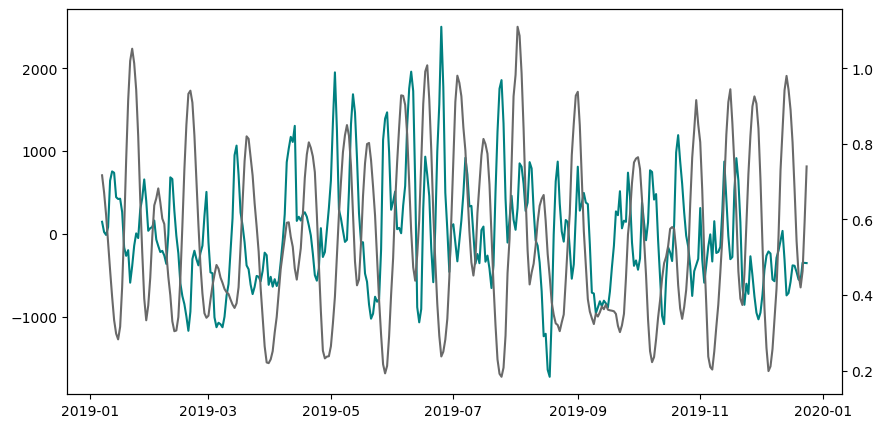

In [73]:
date_prtoadm2019 = list(PRtoadm2019_ros_avg.dropna().index)

mask = np.isin(datelist_dens,date_prtoadm2019)
densdiff_prtoadm2019 = dens_diff_ros[mask]

mask = np.isin(datelist_tides,date_prtoadm2019)
tides_prtoadm2019 = tides[mask]

corr,p = stats.spearmanr(densdiff_prtoadm2019,PRtoadm2019_ros_avg.dropna())
print(corr)
slope,intercept = np.polyfit(densdiff_prtoadm2019,PRtoadm2019_ros_avg.dropna(),1)
res_prtoadm2019 = PRtoadm2019_ros_avg.dropna() - (slope*densdiff_prtoadm2019+intercept)

print('Correlations of different times (best fit line separate for each year) - PR to vs 2019')
print(stats.spearmanr(tides_prtoadm2019,res_prtoadm2019)[0])
print(stats.spearmanr(tides_prtoadm2019[110:240],res_prtoadm2019[110:240])[0])
print(stats.spearmanr(tides_prtoadm2019[:110],res_prtoadm2019[:110])[0])
print(stats.spearmanr(tides_prtoadm2019[240:379],res_prtoadm2019[240:379])[0])

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_prtoadm2019,color='teal')
ax2 = ax.twinx()
ax2.plot(date_prtoadm2019[0:379],tides_prtoadm2019[0:379],color='dimgrey')

In [74]:
mask = np.isin(datelist_winds,date_prtoadm2017)
winds_prtoadm2017 = y_mean4[mask]
mask = np.isin(datelist_winds,date_prtoadm2018)
winds_prtoadm2018 = y_mean4[mask]
mask = np.isin(datelist_winds,date_prtoadm2019)
winds_prtoadm2019 = y_mean4[mask]

date_prtoadm2020 = list(PRtoadm2020_ros_avg.dropna().index)

mask = np.isin(datelist_dens,date_prtoadm2020)
densdiff_prtoadm2020 = dens_diff_ros[mask]

mask = np.isin(datelist_tides,date_prtoadm2020)
tides_prtoadm2020 = tides[mask]

mask = np.isin(datelist_winds,date_prtoadm2020)
winds_prtoadm2020 = y_mean4[mask]

corr,p = stats.spearmanr(densdiff_prtoadm2020,PRtoadm2020_ros_avg.dropna())
print(corr)

slope,intercept = np.polyfit(densdiff_prtoadm2020,PRtoadm2020_ros_avg.dropna(),1)
res_prtoadm2020 = PRtoadm2020_ros_avg.dropna() - (slope*densdiff_prtoadm2020+intercept)

date_prtoadm2021 = list(PRtoadm2021_ros_avg.dropna().index)

mask = np.isin(datelist_dens,date_prtoadm2021)
densdiff_prtoadm2021 = dens_diff_ros[mask]

mask = np.isin(datelist_tides,date_prtoadm2021)
tides_prtoadm2021 = tides[mask]

mask = np.isin(datelist_winds,date_prtoadm2021)
winds_prtoadm2021 = y_mean4[mask]

corr,p = stats.spearmanr(densdiff_prtoadm2021,PRtoadm2021_ros_avg.dropna())
print(corr)
slope,intercept = np.polyfit(densdiff_prtoadm2021,PRtoadm2021_ros_avg.dropna(),1)
res_prtoadm2021 = PRtoadm2021_ros_avg.dropna() - (slope*densdiff_prtoadm2021+intercept)

0.7492996734295976
0.7663799975287772


Text(0, 0.5, 'Tide velocity')

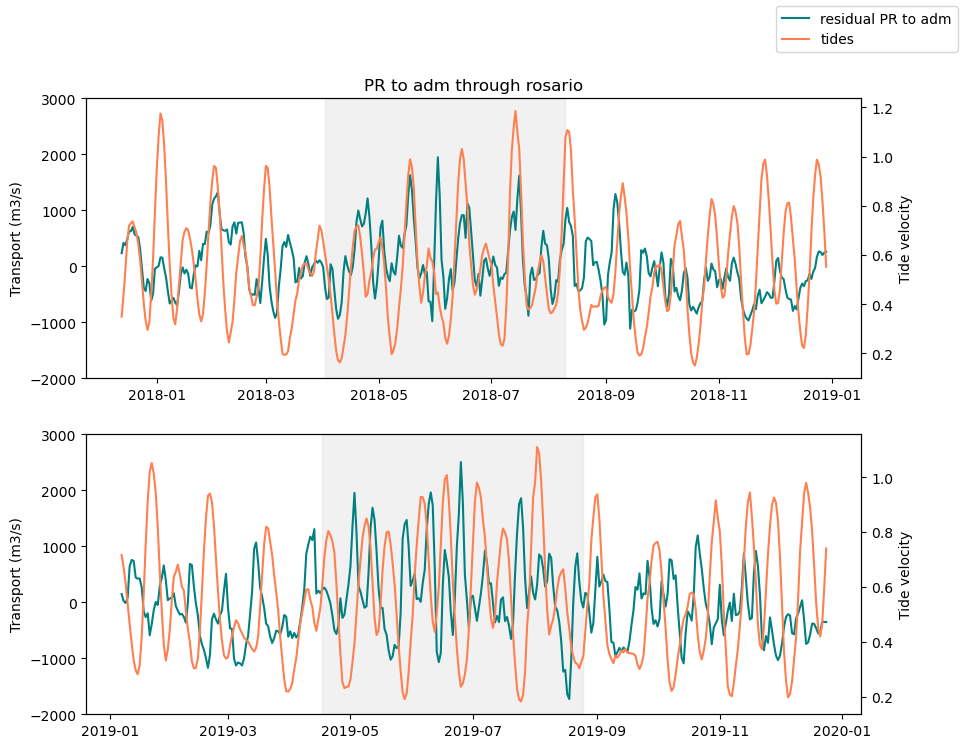

In [75]:
fig,[ax,ax4] = plt.subplots(2,1,figsize=(10,8))

ax.plot(res_prtoadm2018,color='teal',label='residual PR to adm')
ax2 = ax.twinx()
ax2.plot(date_prtoadm2018,tides_prtoadm2018,color='coral',label='tides')
ax.set_title(f'PR to adm through rosario')
ax.set_ylim([-2000,3000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtoadm2018[110],x2=date_prtoadm2018[240],color='lightgrey', alpha=0.3)
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
fig.legend()

ax4.plot(res_prtoadm2019,color='teal')
ax42 = ax4.twinx()
ax42.plot(date_prtoadm2019[0:379],tides_prtoadm2019[0:379],color='coral')
ax4.set_ylim([-2000,3000])
ax4.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtoadm2019[100],x2=date_prtoadm2019[230],color='lightgrey', alpha=0.3)
ax4.set_ylabel('Transport (m3/s)')
ax42.set_ylabel('Tide velocity')

In [76]:
print('Correlations of tides with PRtoadm residual')
corr,p = stats.spearmanr(tides_prtoadm2017[110:240],res_prtoadm2017[110:240])
print('2017',corr)
corr,p = stats.spearmanr(tides_prtoadm2018[110:240],res_prtoadm2018[110:240])
print('2018',corr)
corr,p = stats.spearmanr(tides_prtoadm2019[100:230],res_prtoadm2019[100:230])
print('2019',corr)

Correlations of tides with PRtoadm residual
2017 0.20448456212702618
2018 0.5629163309617775
2019 -0.2239304100834369


Text(0.5, 1.0, 'Age of particles from PR to VS vs. adm')

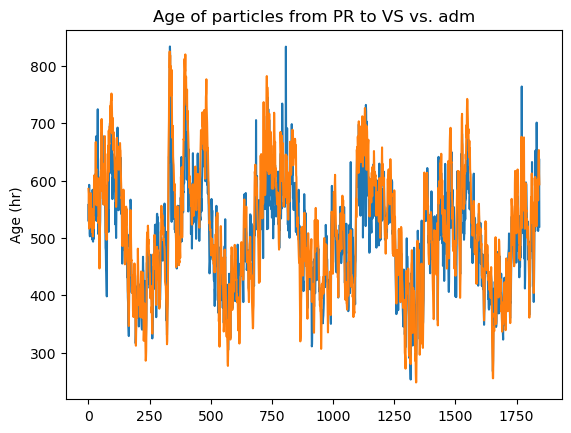

In [77]:
plt.plot(age_2018['forpr_ros3'][2],label='PR to adm')
plt.plot(age_2018['forpr_ros3'][4],label='PR to vicsill')
plt.ylabel('Age (hr)')
plt.title('Age of particles from PR to VS vs. adm')

Look @ with winds

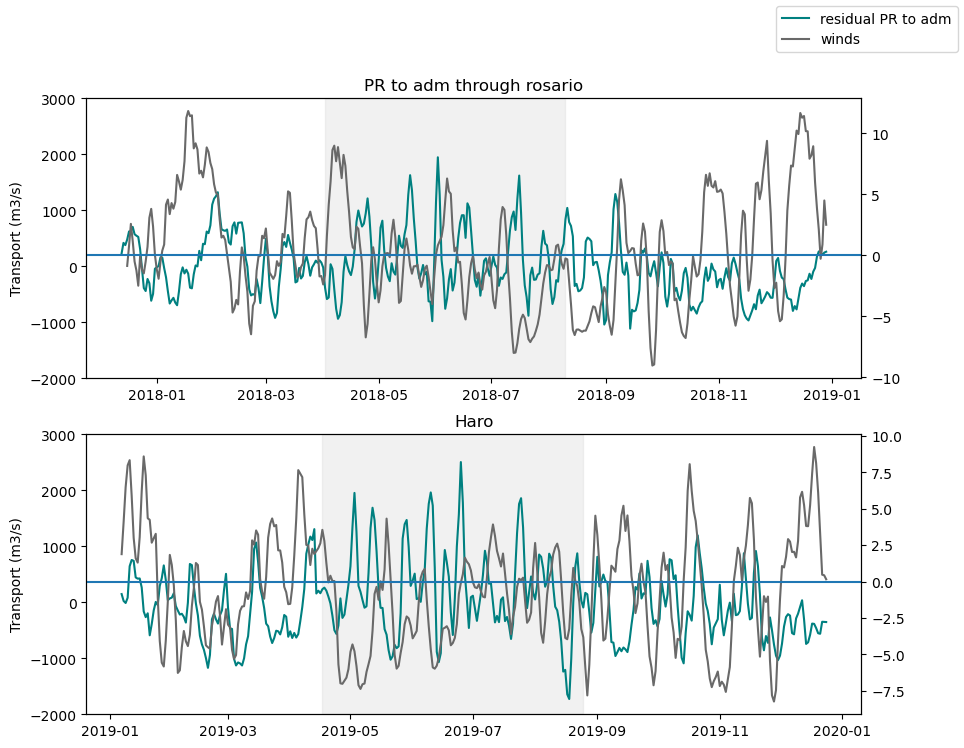

In [78]:
fig,[ax,ax4] = plt.subplots(2,1,figsize=(10,8))

ax.plot(res_prtoadm2018,color='teal',label='residual PR to adm')
ax3 = ax.twinx()
ax3.plot(date_winds_2018sh,winds2018,color='dimgrey',label='winds')
ax.set_title(f'PR to adm through rosario')
ax.set_ylim([-2000,3000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtoadm2018[110],x2=date_prtoadm2018[240],color='lightgrey', alpha=0.3)
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
fig.legend()
ax4.plot(res_prtoadm2019,color='teal')
ax43 = ax4.twinx()
ax43.plot(date_winds_2019sh,winds2019,color='dimgrey')
ax4.set_title('Haro')
ax4.set_ylim([-2000,3000])
ax4.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtoadm2019[100],x2=date_prtoadm2019[230],color='lightgrey', alpha=0.3)
ax4.set_ylabel('Transport (m3/s)')
ax42.set_ylabel('Tide velocity')
ax3.axhline(0)
ax43.axhline(0)

In [79]:
print('-- PR to adm res and winds --')
corr,p = stats.spearmanr(res_prtoadm2017[100:230],winds_prtoadm2017[100:230])
print('2017:',corr)
corr,p = stats.spearmanr(res_prtoadm2018[100:230],winds_prtoadm2018[100:230])
print('2018:',corr)
corr,p = stats.spearmanr(res_prtoadm2019[100:230],winds_prtoadm2019[100:230])
print('2019',corr)
corr,p = stats.spearmanr(res_prtoadm2020[100:230],winds_prtoadm2020[100:230])
print('2020',corr)
corr,p = stats.spearmanr(res_prtoadm2021[100:230],winds_prtoadm2021[100:230])
print('2021',corr)

print('-- PR to vs --')
corr,p = stats.spearmanr(res_prtovs2017[113:243],winds_prtovs2017[100:230])
print('2017:',corr)
corr,p = stats.spearmanr(res_prtovs2018[113:243],winds_prtovs2018[100:230])
print('2018:',corr)
corr,p = stats.spearmanr(res_prtovs2019[100:230],winds_prtovs2019[100:230])
print('2019',corr)
corr,p = stats.spearmanr(res_prtovs2020[100:230],winds_prtovs2020[100:230])
print('2020',corr)
corr,p = stats.spearmanr(res_prtovs2021[100:230],winds_prtovs2021[100:230])
print('2021',corr)

-- PR to adm res and winds --
2017: 0.04507230741919185
2018: -0.2651272037034508
2019 -0.03145475153286266
2020 -0.15585355528547432
2021 -0.19662428819183655
-- PR to vs --
2017: 0.28561089185978233
2018: 0.24862008220786846
2019 -0.3014734599680454
2020 -0.3417908205765475
2021 -0.32929303964276446


Stronger correlation for PR to vs but consistent signs through the years

#### Look at 2020 and 2021 too

0.01729981248697826
-0.06299963129361318
-0.3893676002676535
-0.21818951508282236
-0.20217946441983367


(18600.0, 18979.0)

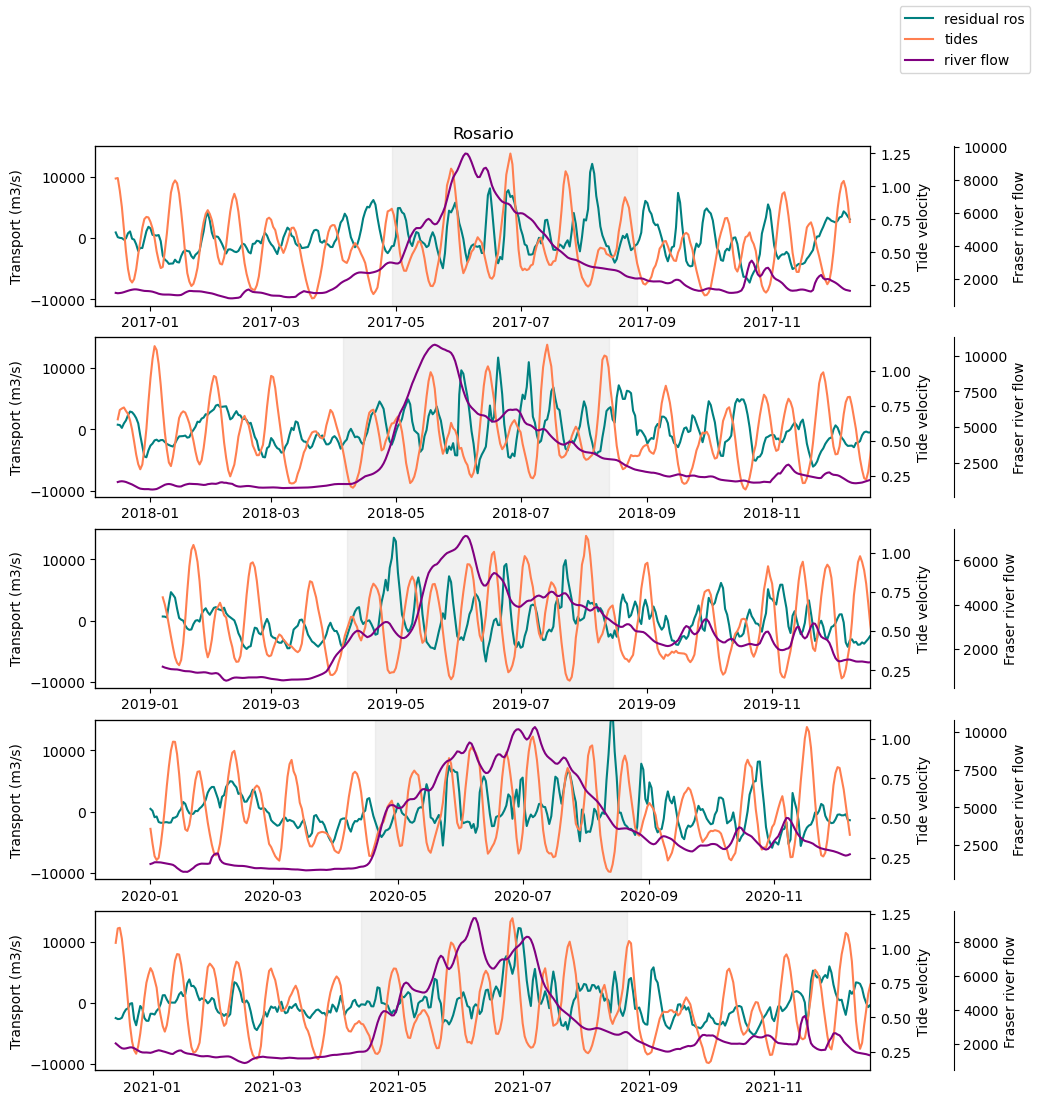

In [80]:
mask = np.isin(datelist_FR,date2017_rossh)
FR_2017 = FR_4mean[mask]
mask = np.isin(datelist_FR,date2018_rossh)
FR_2018 = FR_4mean[mask]
mask = np.isin(datelist_FR,date2019_rossh)
FR_2019 = FR_4mean[mask]
mask = np.isin(datelist_FR,date2020_rossh)
FR_2020 = FR_4mean[mask]
mask = np.isin(datelist_FR,date2021_rossh)
FR_2021 = FR_4mean[mask]

corr,p = stats.spearmanr(tides2017[135:255],res2017[135:255])
print(corr)
corr,p = stats.spearmanr(tides2018[110:240],res2018[110:240])
print(corr)
corr,p = stats.spearmanr(tides2019[110:240],res2019[110:240])
print(corr)
corr,p = stats.spearmanr(tides2020[110:240],res2020[110:240])
print(corr)
corr,p = stats.spearmanr(tides2021[110:240],res2021[110:240])
print(corr)

fig,[ax,ax1,ax4,ax5,ax6] = plt.subplots(5,1,figsize=(10,12))

ax.plot(res2017,color='teal',label='residual ros')
ax2 = ax.twinx()
ax2.plot(date_tides_2017sh,tides2017,color='coral',label='tides')
ax3 = ax.twinx()
ax3.plot(date2017_rossh,FR_2017,color='purple',label='river flow')
ax.set_title('Rosario')
ax.set_ylim([-11000,15000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date2017_rossh[135],x2=date2017_rossh[255],color='lightgrey', alpha=0.3)
ax3.spines['right'].set_position(('outward', 60))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
ax3.set_ylabel('Fraser river flow')
fig.legend()
ax.set_xlim([date_prtovs2017[0]-dt.timedelta(days=10),date_prtovs2017[-1]+dt.timedelta(days=10)])

ax1.plot(res2018,color='teal',label='residual ros')
ax12 = ax1.twinx()
ax12.plot(date_tides_2018sh,tides2018,color='coral',label='tides')
ax13 = ax1.twinx()
ax13.plot(date2018_rossh,FR_2018,color='purple',label='river flow')
ax1.set_ylim([-11000,15000])
ax1.fill_betweenx(y=np.linspace(ax1.get_ylim()[0], ax1.get_ylim()[1], 100),x1=date2018_rossh[110],x2=date2018_rossh[240],color='lightgrey', alpha=0.3)
ax13.spines['right'].set_position(('outward', 60))
ax1.set_ylabel('Transport (m3/s)')
ax12.set_ylabel('Tide velocity')
ax13.set_ylabel('Fraser river flow')
ax1.set_xlim([date_prtovs2017[0]-dt.timedelta(days=10)+dt.timedelta(days=365),date_prtovs2017[-1]+dt.timedelta(days=10)+dt.timedelta(days=365)])

ax4.plot(res2019,color='teal',label='residual ros')
ax42 = ax4.twinx()
ax42.plot(date_tides_2019sh,tides2019,color='coral',label='tides')
ax43 = ax4.twinx()
ax43.plot(date2019_rossh,FR_2019,color='purple',label='river flow')
ax4.set_ylim([-11000,15000])
ax4.fill_betweenx(y=np.linspace(ax4.get_ylim()[0], ax4.get_ylim()[1], 100),x1=date2019_rossh[90],x2=date2019_rossh[220],color='lightgrey', alpha=0.3)
ax43.spines['right'].set_position(('outward', 60))
ax4.set_ylabel('Transport (m3/s)')
ax42.set_ylabel('Tide velocity')
ax43.set_ylabel('Fraser river flow')
ax4.set_xlim([date_prtovs2017[0]-dt.timedelta(days=10)+dt.timedelta(days=2*365),date_prtovs2017[-1]+dt.timedelta(days=10)+dt.timedelta(days=2*365)])

ax5.plot(res2020,color='teal',label='residual ros')
ax52 = ax5.twinx()
ax52.plot(date_tides_2020sh,tides2020,color='coral',label='tides')
ax53 = ax5.twinx()
ax53.plot(date2020_rossh,FR_2020,color='purple',label='river flow')
ax5.set_ylim([-11000,15000])
ax5.fill_betweenx(y=np.linspace(ax5.get_ylim()[0], ax5.get_ylim()[1], 100),x1=date2020_rossh[110],x2=date2020_rossh[240],color='lightgrey', alpha=0.3)
ax53.spines['right'].set_position(('outward', 60))
ax5.set_ylabel('Transport (m3/s)')
ax52.set_ylabel('Tide velocity')
ax53.set_ylabel('Fraser river flow')
ax5.set_xlim([date_prtovs2017[0]-dt.timedelta(days=10)+dt.timedelta(days=3*365),date_prtovs2017[-1]+dt.timedelta(days=10)+dt.timedelta(days=3*365)])

ax6.plot(res2021,color='teal',label='residual ros')
ax62 = ax6.twinx()
ax62.plot(date_tides_2021sh,tides2021,color='coral',label='tides')
ax63 = ax6.twinx()
ax63.plot(date2021_rossh,FR_2021,color='purple',label='river flow')
ax6.set_ylim([-11000,15000])
ax6.fill_betweenx(y=np.linspace(ax6.get_ylim()[0], ax6.get_ylim()[1], 100),x1=date2021_rossh[120],x2=date2021_rossh[250],color='lightgrey', alpha=0.3)
ax63.spines['right'].set_position(('outward', 60))
ax6.set_ylabel('Transport (m3/s)')
ax62.set_ylabel('Tide velocity')
ax63.set_ylabel('Fraser river flow')
ax6.set_xlim([date_prtovs2017[0]-dt.timedelta(days=10)+dt.timedelta(days=4*365),date_prtovs2017[-1]+dt.timedelta(days=10)+dt.timedelta(days=4*365)])

Tides and PRtoadm residual
0.3873046739356899
0.5629163309617775
-0.2616094716574035
0.1691051359434104
0.2040803506807412


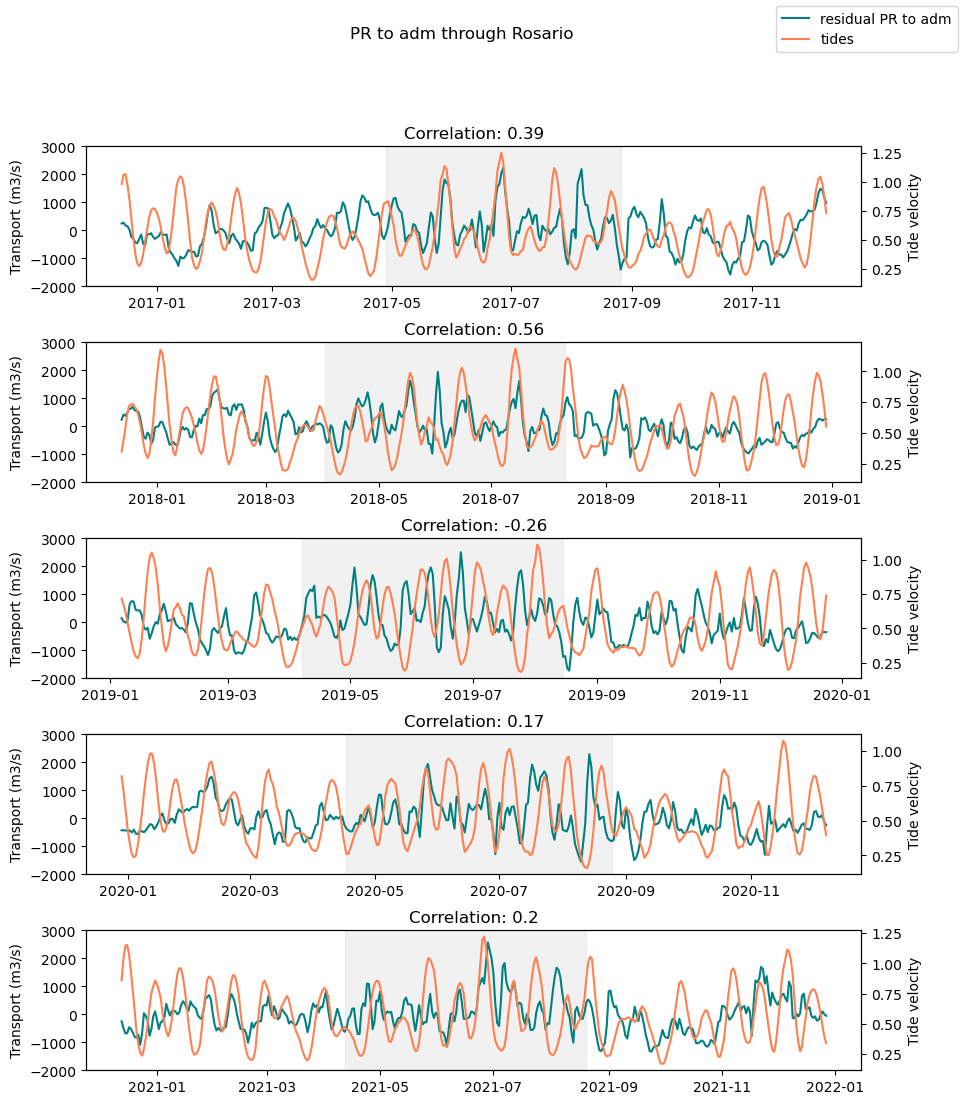

In [81]:
print('Tides and PRtoadm residual')
corr_2017,p = stats.spearmanr(tides_prtoadm2017[135:255],res_prtoadm2017[135:255])
print(corr_2017)
corr_2018,p = stats.spearmanr(tides_prtoadm2018[110:240],res_prtoadm2018[110:240])
print(corr_2018)
corr_2019,p = stats.spearmanr(tides_prtoadm2019[90:220],res_prtoadm2019[90:220])
print(corr_2019)
corr_2020,p = stats.spearmanr(tides_prtoadm2020[110:240],res_prtoadm2020[110:240])
print(corr_2020)
corr_2021,p = stats.spearmanr(tides_prtoadm2021[120:250],res_prtoadm2021[120:250])
print(corr_2021)

fig,[ax1,ax,ax4,ax5,ax6] = plt.subplots(5,1,figsize=(10,12))

ax1.plot(res_prtoadm2017,color='teal',label='residual PR to adm')
ax12 = ax1.twinx()
ax12.plot(date_prtoadm2017,tides_prtoadm2017,color='coral',label='tides')
ax1.set_title(f'Correlation: {np.round(corr_2017,2)}')
ax1.set_ylim([-2000,3000])
ax1.fill_betweenx(y=np.linspace(ax1.get_ylim()[0], ax1.get_ylim()[1], 100),x1=date_prtoadm2017[135],x2=date_prtoadm2017[255],color='lightgrey', alpha=0.3)
ax1.set_ylabel('Transport (m3/s)')
ax12.set_ylabel('Tide velocity')
fig.legend()
fig.suptitle('PR to adm through Rosario')

ax.plot(res_prtoadm2018,color='teal',label='residual PR to adm')
ax2 = ax.twinx()
ax2.plot(date_prtoadm2018,tides_prtoadm2018,color='coral',label='tides')
ax.set_title(f'Correlation: {np.round(corr_2018,2)}')
ax.set_ylim([-2000,3000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtoadm2018[110],x2=date_prtoadm2018[240],color='lightgrey', alpha=0.3)
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
fig.suptitle('PR to adm through Rosario')

ax4.plot(res_prtoadm2019,color='teal')
ax42 = ax4.twinx()
ax42.plot(date_prtoadm2019[0:379],tides_prtoadm2019[0:379],color='coral')
ax4.set_ylim([-2000,3000])
ax4.set_title(f'Correlation: {np.round(corr_2019,2)}')
ax4.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtoadm2019[90],x2=date_prtoadm2019[220],color='lightgrey', alpha=0.3)
# ax43.spines['right'].set_position(('outward', 60))
ax4.set_ylabel('Transport (m3/s)')
ax42.set_ylabel('Tide velocity')

ax5.plot(res_prtoadm2020,color='teal')
ax52 = ax5.twinx()
ax52.plot(date_prtoadm2020,tides_prtoadm2020,color='coral')
ax5.set_ylim([-2000,3000])
ax5.set_title(f'Correlation: {np.round(corr_2020,2)}')
ax5.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtoadm2020[110],x2=date_prtoadm2020[240],color='lightgrey', alpha=0.3)
ax5.set_ylabel('Transport (m3/s)')
ax52.set_ylabel('Tide velocity')

ax6.plot(res_prtoadm2021,color='teal')
ax62 = ax6.twinx()
ax62.plot(date_prtoadm2021,tides_prtoadm2021,color='coral')
ax6.set_ylim([-2000,3000])
ax6.set_title(f'Correlation: {np.round(corr_2021,2)}')
ax6.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtoadm2021[120],x2=date_prtoadm2021[250],color='lightgrey', alpha=0.3)
ax6.set_ylabel('Transport (m3/s)')
ax62.set_ylabel('Tide velocity')

plt.subplots_adjust(hspace=0.4)

### Winds

In [130]:
print('Winds and ros south residual')
corr_2017,p = stats.spearmanr(winds2017,res2017)
print('2017,full:',corr_2017)
corr_2017,p = stats.spearmanr(winds2017[135:255],res2017[135:255])
print('2017,sum:',corr_2017)
corr_2018,p = stats.spearmanr(winds2018,res2018)
print('2018,full:',corr_2018)
corr_2018,p = stats.spearmanr(winds2018[110:240],res2018[110:240])
print('2018,sum:',corr_2018)
corr_2019,p = stats.spearmanr(winds2019,res2019)
print('2019,full:',corr_2019)
corr_2019,p = stats.spearmanr(winds2019[90:220],res2019[90:220])
print('2019,sum:',corr_2019)
corr_2020,p = stats.spearmanr(winds2020,res2020)
print('2020,full:',corr_2020)
corr_2020,p = stats.spearmanr(winds2020[110:240],res2020[110:240])
print('2020,sum:',corr_2020)
corr_2021,p = stats.spearmanr(winds2021,res2021)
print('2021,full:',corr_2021)
corr_2021,p = stats.spearmanr(winds2021[120:250],res2021[120:250])
print('2021,sum:',corr_2021)

Winds and ros south residual
2017,full: -0.18603538607550985
2017,sum: -0.014632960622265432
2018,full: -0.19575566003839853
2018,sum: -0.06366057163145747
2019,full: -0.27519144374668447
2019,sum: -0.3244206530199784
2020,full: -0.1752717698375031
2020,sum: -0.3258845539335509
2021,full: -0.2637455556216839
2021,sum: -0.3283316718786273


In [132]:
print('Winds and PRtoadm residual')
corr_2017,p = stats.spearmanr(winds_prtoadm2017,res_prtoadm2017)
print('2017,full:',corr_2017)
corr_2017,p = stats.spearmanr(winds_prtoadm2017[135:255],res_prtoadm2017[135:255])
print('2017,sum:',corr_2017)
corr_2018,p = stats.spearmanr(winds_prtoadm2018,res_prtoadm2018)
print('2018,full:',corr_2018)
corr_2018,p = stats.spearmanr(winds_prtoadm2018[110:240],res_prtoadm2018[110:240])
print('2018,sum:',corr_2018)
corr_2019,p = stats.spearmanr(winds_prtoadm2019,res_prtoadm2019)
print('2019,full:',corr_2019)
corr_2019,p = stats.spearmanr(winds_prtoadm2019[90:220],res_prtoadm2019[90:220])
print('2019,sum:',corr_2019)
corr_2020,p = stats.spearmanr(winds_prtoadm2020,res_prtoadm2020)
print('2020,full:',corr_2020)
corr_2020,p = stats.spearmanr(winds_prtoadm2020[110:240],res_prtoadm2020[110:240])
print('2020,sum:',corr_2020)
corr_2021,p = stats.spearmanr(winds_prtoadm2021,res_prtoadm2021)
print('2021,full:',corr_2021)
corr_2021,p = stats.spearmanr(winds_prtoadm2021[120:250],res_prtoadm2021[120:250])
print('2021,sum:',corr_2021)

Winds and PRtoadm residual
2017,full: -0.16508623988001406
2017,sum: -0.20108340857003953
2018,full: -0.1385422269429696
2018,sum: -0.26454273580139015
2019,full: -0.009498174158230814
2019,sum: -0.031624083354955
2020,full: -0.09290171092761493
2020,sum: -0.19711589670758853
2021,full: -0.18502089058059523
2021,sum: -0.16708407871198566


In [133]:
print('Winds and PRtovs residual')
corr_2017,p = stats.spearmanr(winds_prtovs2017,res_prtovs2017)
print('2017,full:',corr_2017)
corr_2017,p = stats.spearmanr(winds_prtovs2017[135:255],res_prtovs2017[135:255])
print('2017,sum:',corr_2017)
corr_2018,p = stats.spearmanr(winds_prtovs2018,res_prtovs2018)
print('2018,full:',corr_2018)
corr_2018,p = stats.spearmanr(winds_prtovs2018[110:240],res_prtovs2018[110:240])
print('2018,sum:',corr_2018)
corr_2019,p = stats.spearmanr(winds_prtovs2019,res_prtovs2019)
print('2019,full:',corr_2019)
corr_2019,p = stats.spearmanr(winds_prtovs2019[90:220],res_prtovs2019[90:220])
print('2019,sum:',corr_2019)
corr_2020,p = stats.spearmanr(winds_prtovs2020,res_prtovs2020)
print('2020,full:',corr_2020)
corr_2020,p = stats.spearmanr(winds_prtovs2020[110:240],res_prtovs2020[110:240])
print('2020,sum:',corr_2020)
corr_2021,p = stats.spearmanr(winds_prtovs2021,res_prtovs2021)
print('2021,full:',corr_2021)
corr_2021,p = stats.spearmanr(winds_prtovs2021[120:250],res_prtovs2021[120:250])
print('2021,sum:',corr_2021)

Winds and PRtovs residual
2017,full: -0.17779200971200906
2017,sum: 0.003646086533787068
2018,full: -0.178577049483868
2018,sum: -0.02636933455325076
2019,full: -0.3032910186514883
2019,sum: -0.3542339783419137
2020,full: -0.1835039663706014
2020,sum: -0.3303090305753185
2021,full: -0.24946094347566364
2021,sum: -0.2978410192683227


Winds and PRtoadm residual
-0.20108340857003953
-0.26454273580139015
-0.031624083354955
-0.19711589670758853
-0.16708407871198566


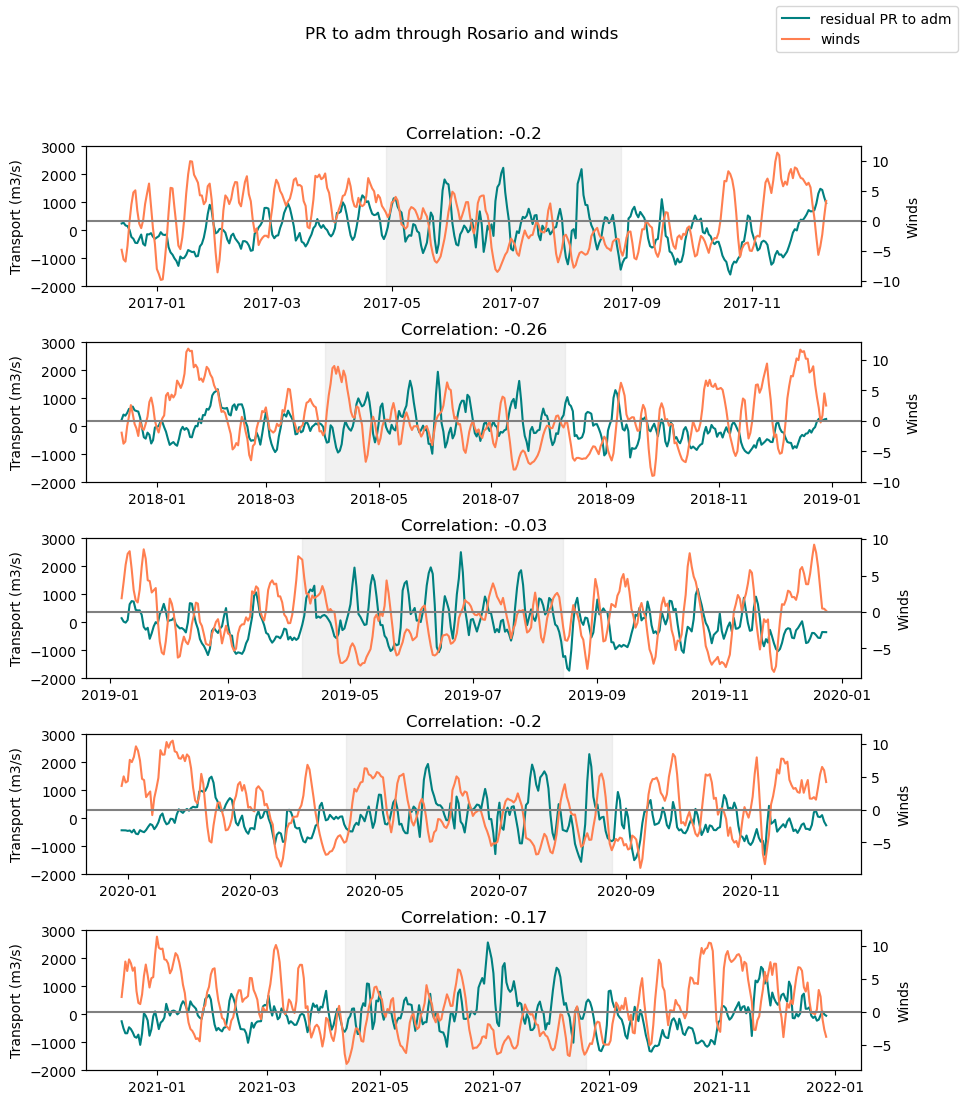

In [135]:
print('Winds and PRtoadm residual')
corr_2017,p = stats.spearmanr(winds_prtoadm2017[135:255],res_prtoadm2017[135:255])
print(corr_2017)
corr_2018,p = stats.spearmanr(winds_prtoadm2018[110:240],res_prtoadm2018[110:240])
print(corr_2018)
corr_2019,p = stats.spearmanr(winds_prtoadm2019[90:220],res_prtoadm2019[90:220])
print(corr_2019)
corr_2020,p = stats.spearmanr(winds_prtoadm2020[110:240],res_prtoadm2020[110:240])
print(corr_2020)
corr_2021,p = stats.spearmanr(winds_prtoadm2021[120:250],res_prtoadm2021[120:250])
print(corr_2021)

fig,[ax1,ax,ax4,ax5,ax6] = plt.subplots(5,1,figsize=(10,12))

ax1.plot(res_prtoadm2017,color='teal',label='residual PR to adm')
ax12 = ax1.twinx()
ax12.plot(date_prtoadm2017,winds_prtoadm2017,color='coral',label='winds')
ax1.set_title(f'Correlation: {np.round(corr_2017,2)}')
ax1.set_ylim([-2000,3000])
ax1.fill_betweenx(y=np.linspace(ax1.get_ylim()[0], ax1.get_ylim()[1], 100),x1=date_prtoadm2017[135],x2=date_prtoadm2017[255],color='lightgrey', alpha=0.3)
ax1.set_ylabel('Transport (m3/s)')
ax12.set_ylabel('Winds')
ax12.axhline(0,color='grey')
fig.legend()
fig.suptitle('PR to adm through Rosario and winds')

ax.plot(res_prtoadm2018,color='teal',label='residual PR to adm')
ax2 = ax.twinx()
ax2.plot(date_prtoadm2018,winds_prtoadm2018,color='coral',label='winds')
ax.set_title(f'Correlation: {np.round(corr_2018,2)}')
ax.set_ylim([-2000,3000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtoadm2018[110],x2=date_prtoadm2018[240],color='lightgrey', alpha=0.3)
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Winds')
ax2.axhline(0,color='grey')
fig.suptitle('PR to adm through Rosario and winds')

ax4.plot(res_prtoadm2019,color='teal')
ax42 = ax4.twinx()
ax42.plot(date_prtoadm2019[0:379],winds_prtoadm2019[0:379],color='coral')
ax4.set_ylim([-2000,3000])
ax4.set_title(f'Correlation: {np.round(corr_2019,2)}')
ax4.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtoadm2019[90],x2=date_prtoadm2019[220],color='lightgrey', alpha=0.3)
# ax43.spines['right'].set_position(('outward', 60))
ax4.set_ylabel('Transport (m3/s)')
ax42.set_ylabel('Winds')
ax42.axhline(0,color='grey')

ax5.plot(res_prtoadm2020,color='teal')
ax52 = ax5.twinx()
ax52.plot(date_prtoadm2020,winds_prtoadm2020,color='coral')
ax5.set_ylim([-2000,3000])
ax5.set_title(f'Correlation: {np.round(corr_2020,2)}')
ax5.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtoadm2020[110],x2=date_prtoadm2020[240],color='lightgrey', alpha=0.3)
ax5.set_ylabel('Transport (m3/s)')
ax52.set_ylabel('Winds')
ax52.axhline(0,color='grey')

ax6.plot(res_prtoadm2021,color='teal')
ax62 = ax6.twinx()
ax62.plot(date_prtoadm2021,winds_prtoadm2021,color='coral')
ax6.set_ylim([-2000,3000])
ax6.set_title(f'Correlation: {np.round(corr_2021,2)}')
ax6.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtoadm2021[120],x2=date_prtoadm2021[250],color='lightgrey', alpha=0.3)
ax6.set_ylabel('Transport (m3/s)')
ax62.set_ylabel('Winds')
ax62.axhline(0,color='grey')

plt.subplots_adjust(hspace=0.4)

Tides and PRtoVS residual
-0.07363011320230571
-0.16044190143249257
-0.3651913859263406
-0.25834300618607375
-0.2925316472982015


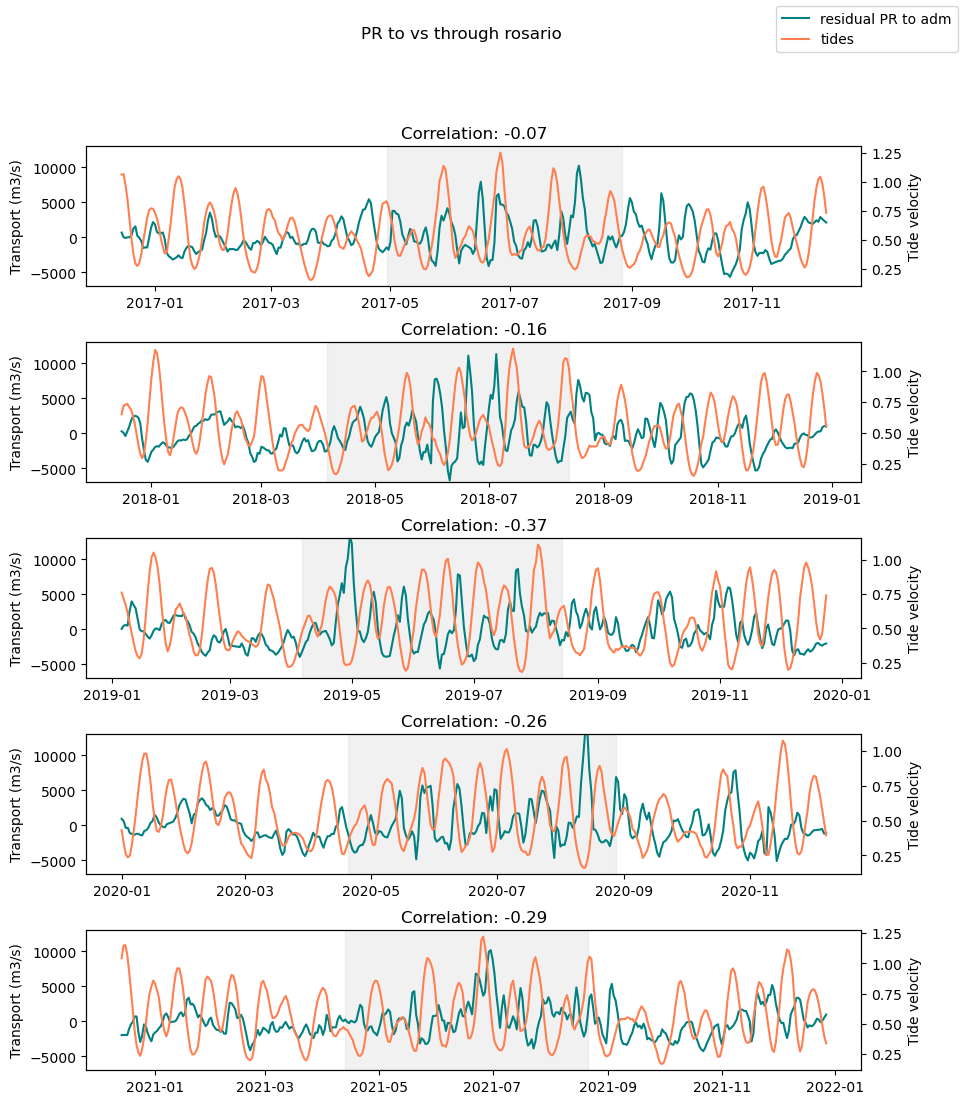

In [83]:
print('Tides and PRtoVS residual')
corr_2017,p = stats.spearmanr(tides_prtovs2017[135:255],res_prtovs2017[135:255])
print(corr_2017)
corr_2018,p = stats.spearmanr(tides_prtovs2018[110:240],res_prtovs2018[110:240])
print(corr_2018)
corr_2019,p = stats.spearmanr(tides_prtovs2019[90:220],res_prtovs2019[90:220])
print(corr_2019)
corr_2020,p = stats.spearmanr(tides_prtovs2020[110:240],res_prtovs2020[110:240])
print(corr_2020)
corr_2021,p = stats.spearmanr(tides_prtovs2021[120:250],res_prtovs2021[120:250])
print(corr_2021)

fig,[ax1,ax,ax4,ax5,ax6] = plt.subplots(5,1,figsize=(10,12))

ax1.plot(res_prtovs2017,color='teal',label='residual PR to adm')
ax12 = ax1.twinx()
ax12.plot(date_prtovs2017,tides_prtovs2017,color='coral',label='tides')
ax1.set_title(f'Correlation: {np.round(corr_2017,2)}')
ax1.set_ylim([-7000,13000])
ax1.fill_betweenx(y=np.linspace(ax1.get_ylim()[0], ax1.get_ylim()[1], 100),x1=date_prtovs2017[135],x2=date_prtovs2017[255],color='lightgrey', alpha=0.3)
ax1.set_ylabel('Transport (m3/s)')
ax12.set_ylabel('Tide velocity')
fig.legend()
fig.suptitle('PR to vs through rosario')

ax.plot(res_prtovs2018,color='teal',label='residual PR to adm')
ax2 = ax.twinx()
ax2.plot(date_prtovs2018,tides_prtovs2018,color='coral',label='tides')
ax.set_title(f'Correlation: {np.round(corr_2018,2)}')
ax.set_ylim([-7000,13000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtovs2018[110],x2=date_prtovs2018[240],color='lightgrey', alpha=0.3)
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
fig.suptitle('PR to vs through rosario')

ax4.plot(res_prtovs2019,color='teal')
ax42 = ax4.twinx()
ax42.plot(date_prtovs2019[0:379],tides_prtovs2019[0:379],color='coral')
ax4.set_ylim([-7000,13000])
ax4.set_title(f'Correlation: {np.round(corr_2019,2)}')
ax4.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtovs2019[90],x2=date_prtovs2019[220],color='lightgrey', alpha=0.3)
# ax43.spines['right'].set_position(('outward', 60))
ax4.set_ylabel('Transport (m3/s)')
ax42.set_ylabel('Tide velocity')

ax5.plot(res_prtovs2020,color='teal')
ax52 = ax5.twinx()
ax52.plot(date_prtovs2020,tides_prtovs2020,color='coral')
ax5.set_ylim([-7000,13000])
ax5.set_title(f'Correlation: {np.round(corr_2020,2)}')
ax5.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtovs2020[110],x2=date_prtovs2020[240],color='lightgrey', alpha=0.3)
ax5.set_ylabel('Transport (m3/s)')
ax52.set_ylabel('Tide velocity')

ax6.plot(res_prtovs2021,color='teal')
ax62 = ax6.twinx()
ax62.plot(date_prtovs2021,tides_prtovs2021,color='coral')
ax6.set_ylim([-7000,13000])
ax6.set_title(f'Correlation: {np.round(corr_2021,2)}')
ax6.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtovs2021[120],x2=date_prtovs2021[250],color='lightgrey', alpha=0.3)
ax6.set_ylabel('Transport (m3/s)')
ax62.set_ylabel('Tide velocity')
plt.subplots_adjust(hspace=0.4)


### Winds

0.003646086533787068
-0.02636933455325076
-0.3542339783419137
-0.3303090305753185
-0.2978410192683227


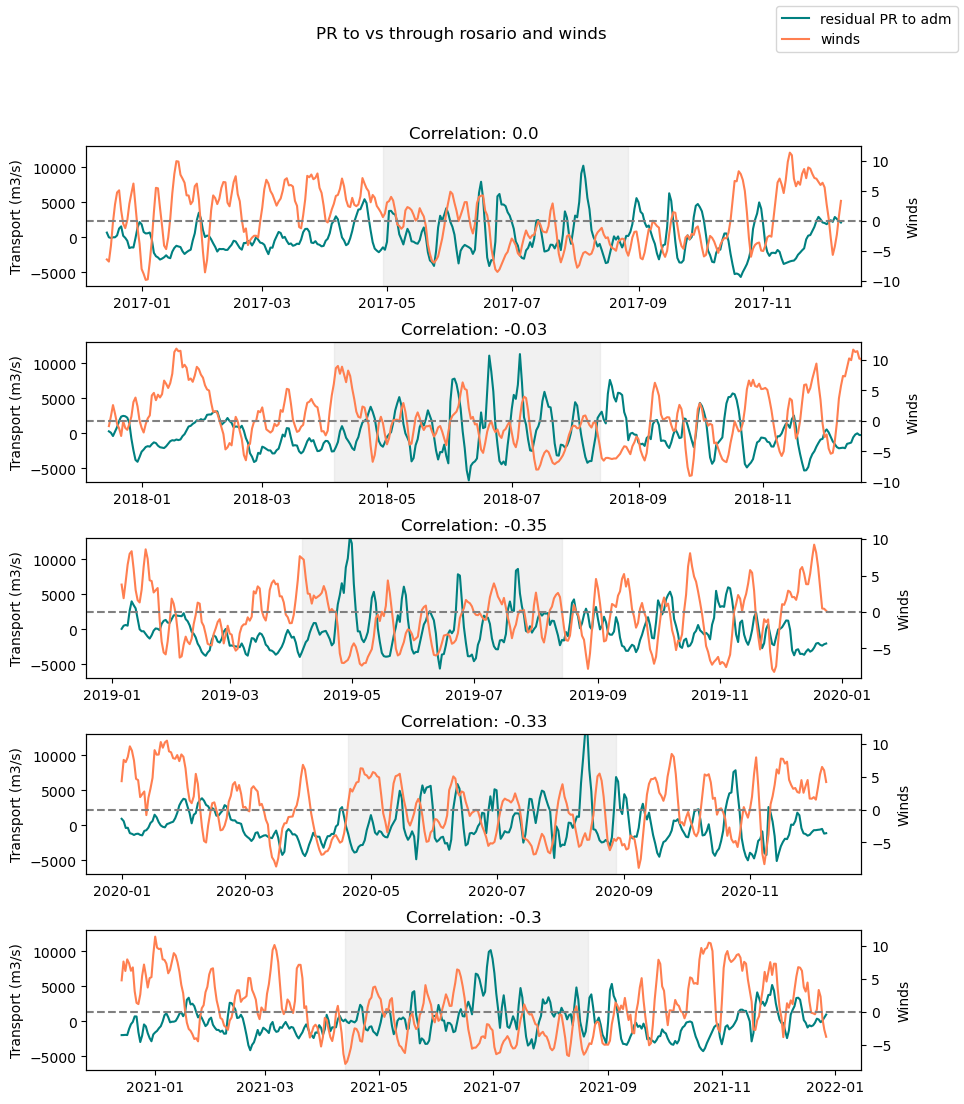

In [84]:
#print('Winds and PRtoVS residual')
corr_2017,p = stats.spearmanr(winds_prtovs2017[135:255],res_prtovs2017[135:255])
print(corr_2017)
corr_2018,p = stats.spearmanr(winds_prtovs2018[110:240],res_prtovs2018[110:240])
print(corr_2018)
corr_2019,p = stats.spearmanr(winds_prtovs2019[90:220],res_prtovs2019[90:220])
print(corr_2019)
corr_2020,p = stats.spearmanr(winds_prtovs2020[110:240],res_prtovs2020[110:240])
print(corr_2020)
corr_2021,p = stats.spearmanr(winds_prtovs2021[120:250],res_prtovs2021[120:250])
print(corr_2021)

fig,[ax1,ax,ax4,ax5,ax6] = plt.subplots(5,1,figsize=(10,12))

ax1.plot(res_prtovs2017,color='teal',label='residual PR to adm')
ax12 = ax1.twinx()
ax12.plot(date_prtovs2017,winds_prtovs2017,color='coral',label='winds')
ax1.set_title(f'Correlation: {np.round(corr_2017,2)}')
ax1.set_ylim([-7000,13000])
ax1.fill_betweenx(y=np.linspace(ax1.get_ylim()[0], ax1.get_ylim()[1], 100),x1=date_prtovs2017[135],x2=date_prtovs2017[255],color='lightgrey', alpha=0.3)
ax1.set_ylabel('Transport (m3/s)')
ax12.set_ylabel('Winds')
fig.legend()
fig.suptitle('PR to vs through rosario and winds')
ax1.set_xlim([date_prtovs2017[0]-dt.timedelta(days=10),date_prtovs2017[-1]+dt.timedelta(days=10)])

ax.plot(res_prtovs2018,color='teal',label='residual PR to adm')
ax2 = ax.twinx()
ax2.plot(date_prtovs2018,winds_prtovs2018,color='coral',label='winds')
ax.set_title(f'Correlation: {np.round(corr_2018,2)}')
ax.set_ylim([-7000,13000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtovs2018[110],x2=date_prtovs2018[240],color='lightgrey', alpha=0.3)
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Winds')
fig.suptitle('PR to vs through rosario and winds')
ax.set_xlim([date_prtovs2017[0]-dt.timedelta(days=10)+dt.timedelta(days=365),date_prtovs2017[-1]+dt.timedelta(days=10)+dt.timedelta(days=365)])

ax4.plot(res_prtovs2019,color='teal')
ax42 = ax4.twinx()
ax42.plot(date_prtovs2019[0:379],winds_prtovs2019[0:379],color='coral')
ax4.set_ylim([-7000,13000])
ax4.set_title(f'Correlation: {np.round(corr_2019,2)}')
ax4.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtovs2019[90],x2=date_prtovs2019[220],color='lightgrey', alpha=0.3)
# ax43.spines['right'].set_position(('outward', 60))
ax4.set_ylabel('Transport (m3/s)')
ax42.set_ylabel('Winds')

ax5.plot(res_prtovs2020,color='teal')
ax52 = ax5.twinx()
ax52.plot(date_prtovs2020,winds_prtovs2020,color='coral')
ax5.set_ylim([-7000,13000])
ax5.set_title(f'Correlation: {np.round(corr_2020,2)}')
ax5.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtovs2020[110],x2=date_prtovs2020[240],color='lightgrey', alpha=0.3)
ax5.set_ylabel('Transport (m3/s)')
ax52.set_ylabel('Winds')

ax6.plot(res_prtovs2021,color='teal')
ax62 = ax6.twinx()
ax62.plot(date_prtovs2021,winds_prtovs2021,color='coral')
ax6.set_ylim([-7000,13000])
ax6.set_title(f'Correlation: {np.round(corr_2021,2)}')
ax6.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtovs2021[120],x2=date_prtovs2021[250],color='lightgrey', alpha=0.3)
ax6.set_ylabel('Transport (m3/s)')
ax62.set_ylabel('Winds')
plt.subplots_adjust(hspace=0.4)

ax12.axhline(0,color='grey',ls='--')
ax2.axhline(0,color='grey',ls='--')
ax42.axhline(0,color='grey',ls='--')
ax52.axhline(0,color='grey',ls='--')
ax62.axhline(0,color='grey',ls='--')

In [85]:
winds_prtovs2017[135:255].max()

4.879414675

Correlation between PRtoVS and PRtoadm
2017 0.6048966427210086
2018 0.3084970561848773
2019 0.4562821503331418
2020 0.40697198620661756
2021 0.47136993759685053


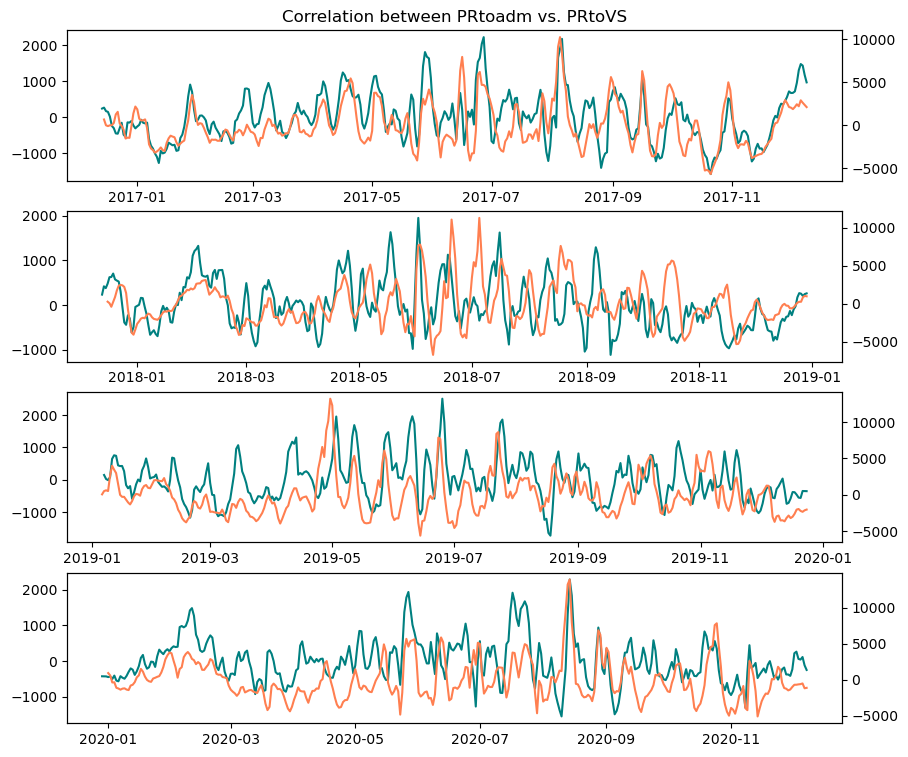

In [86]:
fig,[ax1,ax,ax3,ax4] = plt.subplots(4,1,figsize=(10,9))
ax1.plot(res_prtoadm2017,color='teal')
ax12 = ax1.twinx()
ax12.plot(res_prtovs2017,color='coral')
ax.plot(res_prtoadm2018,color='teal')
ax2 = ax.twinx()
ax2.plot(res_prtovs2018,color='coral')
ax3.plot(res_prtoadm2019,color='teal')
ax32 = ax3.twinx()
ax32.plot(res_prtovs2019,color='coral')
ax4.plot(res_prtoadm2020,color='teal')
ax42 = ax4.twinx()
ax42.plot(res_prtovs2020,color='coral')
ax5.plot(res_prtoadm2021,color='teal')
ax52 = ax5.twinx()
ax52.plot(res_prtovs2021,color='coral')
ax1.set_title('Correlation between PRtoadm vs. PRtoVS')
print('Correlation between PRtoVS and PRtoadm')
corr,p = stats.spearmanr(res_prtoadm2017[1:],res_prtovs2017)
print('2017',corr)
corr,p = stats.spearmanr(res_prtoadm2018[3:],res_prtovs2018)
print('2018',corr)
corr,p = stats.spearmanr(res_prtoadm2019,res_prtovs2019[1:])
print('2019',corr)
corr,p = stats.spearmanr(res_prtoadm2020[3:],res_prtovs2020)
print('2020',corr)
corr,p = stats.spearmanr(res_prtoadm2021[1:],res_prtovs2021)
print('2021',corr)

In [87]:
#Check timing of tides files
corr,p = stats.spearmanr(res_prtoadm2018[103:233],tides_prtovs2018[100:230])
print(corr)
corr,p = stats.spearmanr(res_prtoadm2018[103:233],tides_prtoadm2018[103:233])
print(corr)

0.5493697851943902
0.5493697851943902


In [88]:
print(res_prtoadm2018[103])
print(tides_prtoadm2018[103:104])
print(res_prtoadm2018[103])
print(tides_prtovs2018[100:101])

-19.477581893256
815    0.514829
Name: vozocrtx, dtype: float64
-19.477581893256
815    0.514829
Name: vozocrtx, dtype: float64


In [89]:
#Calculating cummulative river flow
print('Cummulative river flow in summer')
print('2017:',np.sum(FR_2017[110:240]))
print('2018:',np.sum(FR_2018[110:240]))
print('2019:',np.sum(FR_2019[110:240]))
print('2020:',np.sum(FR_2020[110:240]))
print('2021:',np.sum(FR_2021[110:240]))

Cummulative river flow in summer
2017: 631252.5
2018: 687559.75
2019: 559845.0
2020: 887910.0
2021: 671137.5


In [90]:
#Calculating cummulative river flow 
print('Cummulative river flow')
print('2017:',np.sum(FR_2017))
print('2018:',np.sum(FR_2018))
print('2019:',np.sum(FR_2019))
print('2020:',np.sum(FR_2020))
print('2021:',np.sum(FR_2021))

Cummulative river flow
2017: 972134.0
2018: 1001100.0
2019: 948207.5
2020: 1280933.5
2021: 1108483.5


In [91]:
wind

time      wind
0     2016-01-01  1.081336
1     2016-01-02  2.314867
2     2016-01-03 -1.717002
3     2016-01-04 -1.563365
4     2016-01-05  1.748916
...          ...       ...
2552  2022-12-27  7.833456
2553  2022-12-28  4.378495
2554  2022-12-29  7.861543
2555  2022-12-30  8.554890
2556  2022-12-31  6.952309

[2557 rows x 2 columns]

In [92]:
print('2017:',np.quantile(winds_prtovs2017[135:255],0.75),np.quantile(winds_prtovs2017[135:255],0.25),np.mean(winds_prtovs2017[135:255]))

2017: 0.9505281624999989 -4.582916493750001 -1.8846268799666677


In [93]:
#Winds
print('Winds, upper quartile, lower quartile and mean')
## PR to adm
print('2017:',np.quantile(winds_prtoadm2017[135:255],0.75),np.quantile(winds_prtoadm2017[135:255],0.25),np.mean(winds_prtoadm2017[135:255]))
print('2018:',np.quantile(winds_prtoadm2018[110:240],0.75),np.quantile(winds_prtoadm2018[110:240],0.25),np.mean(winds_prtoadm2018[110:240]))
print('2019:',np.quantile(winds_prtoadm2019[110:240],0.75),np.quantile(winds_prtoadm2019[110:240],0.25),np.mean(winds_prtoadm2019[110:240]))
print('2020:',np.quantile(winds_prtoadm2020[110:240],0.75),np.quantile(winds_prtoadm2020[110:240],0.25),np.mean(winds_prtoadm2020[110:240]))
print('2021:',np.quantile(winds_prtoadm2021[110:240],0.75),np.quantile(winds_prtoadm2021[110:240],0.25),np.mean(winds_prtoadm2021[110:240]))

Winds, upper quartile, lower quartile and mean
2017: 0.989585531249999 -4.532472006250001 -1.8315399755916677
2018: 0.8663016437499991 -2.858298950000002 -0.6496486296153857
2019: 0.2710376368749998 -3.9426037000000003 -1.8134824143923078
2020: 2.4552044675 -3.56844504375 -0.4025889041769226
2021: 0.19809349362499995 -4.09325561875 -1.7613191541365385


In [94]:
#Tides
print('Tides, upper quartile, lower quartile and mean')
## PRtoadm
print('2017:',np.quantile(tides_prtoadm2017[135:255],0.75),np.quantile(tides_prtoadm2017[135:255],0.25),np.mean(tides_prtoadm2017[135:255]))
print('2018:',np.quantile(tides_prtoadm2018[110:240],0.75),np.quantile(tides_prtoadm2018[110:240],0.25),np.mean(tides_prtoadm2018[110:240]))
print('2019:',np.quantile(tides_prtoadm2019[110:240],0.75),np.quantile(tides_prtoadm2019[110:240],0.25),np.mean(tides_prtoadm2019[110:240]))
print('2020:',np.quantile(tides_prtoadm2020[100:230],0.75),np.quantile(tides_prtoadm2020[110:240],0.25),np.mean(tides_prtoadm2020[110:240]))
print('2021:',np.quantile(tides_prtoadm2021[110:240],0.75),np.quantile(tides_prtoadm2021[110:240],0.25),np.mean(tides_prtoadm2021[110:240]))

Tides, upper quartile, lower quartile and mean
2017: 0.7040802875000001 0.405788585 0.5790926653125
2018: 0.6329694931250001 0.385968609375 0.5398612046153847
2019: 0.7814925556250001 0.4074575418750001 0.5923913279615387
2020: 0.7692043925000002 0.3760153968750002 0.5672619933269232
2021: 0.75762863375 0.38177375125000007 0.5701979280000001


In [95]:
mask = np.isin(datelist_tides,datelist_vs)
tides18to21 = tides.vozocrtx[mask]


plt.plot(np.arange(0,130),tides_prtoadm2018[100:230])
plt.plot(np.arange(0,130),tides_prtoadm2019[100:230])
plt.title('Comparing tides in 2018 and 2019')
# plt.plot(np.arange(260,390),tides_prtoadm2020[100:230])
# plt.plot(np.arange(390,520),tides_prtoadm2021[100:230])

AttributeError: 'Series' object has no attribute 'vozocrtx'

Text(0, 0.5, 'Wind (m/s)')

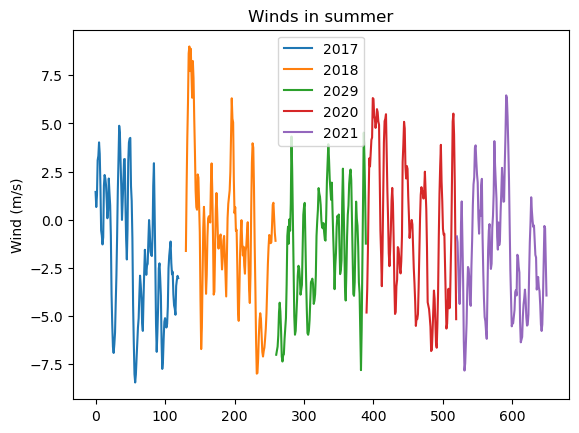

In [ ]:
plt.plot(np.arange(0,120),winds_prtoadm2017[135:255],label='2017')
plt.plot(np.arange(130,260),winds_prtoadm2018[110:240],label='2018')
plt.plot(np.arange(260,390),winds_prtoadm2019[110:240],label='2029')
plt.plot(np.arange(390,520),winds_prtoadm2020[110:240],label='2020')
plt.plot(np.arange(520,650),winds_prtoadm2021[110:240],label='2021')
plt.title('Winds in summer')
plt.legend()
plt.ylabel('Wind (m/s)')

#### Look at differences in total transport through the years

In [ ]:
print('Tides and residual')
corr,p = stats.spearmanr(tides2017[110:240],res2017[110:240])
print('2017:',corr)
corr,p = stats.spearmanr(tides2018[110:240],res2018[110:240])
print('2018:',corr)
corr,p = stats.spearmanr(tides2019[110:240],res2019[110:240])
print('2019:',corr)
corr,p = stats.spearmanr(tides2020[110:240],res2020[110:240])
print('2020',corr)
corr,p = stats.spearmanr(tides2021[110:240],res2021[110:240])
print('2021:',corr)

Tides and residual
2017: -0.14586297778202623
2018: -0.06299963129361318
2019: -0.3893676002676535
2020 -0.21818951508282236
2021: -0.20217946441983367


Text(0.5, 1.0, 'Comparing residual in each year')

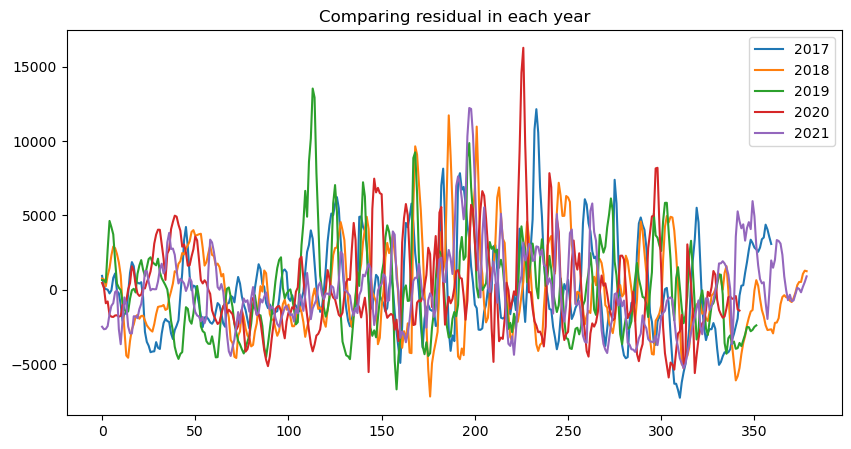

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(np.arange(0,len(res2017)),res2017,label='2017')
ax.plot(np.arange(0,len(res2018)),res2018,label='2018')
ax.plot(np.arange(0,len(res2019)),res2019,label='2019')
ax.plot(np.arange(0,len(res2020)),res2020,label='2020')
ax.plot(np.arange(0,len(res2021)),res2021,label='2021')
ax.legend()
ax.set_title('Comparing residual in each year')

No significant differences between years

Text(0.5, 1.0, 'Comparing residual in summer between years')

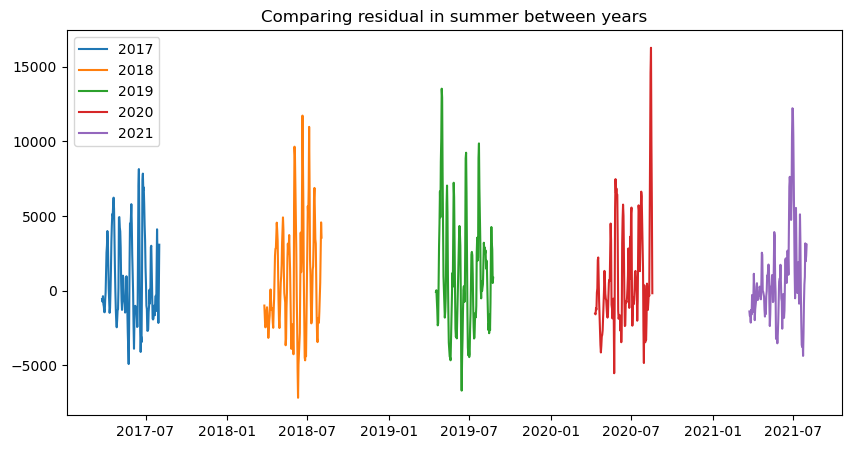

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res2017[100:230],label='2017')
ax.plot(res2018[100:230],label='2018')
ax.plot(res2019[100:230],label='2019')
ax.plot(res2020[100:230],label='2020')
ax.plot(res2021[100:230],label='2021')
ax.legend()
ax.set_title('Comparing residual in summer between years')

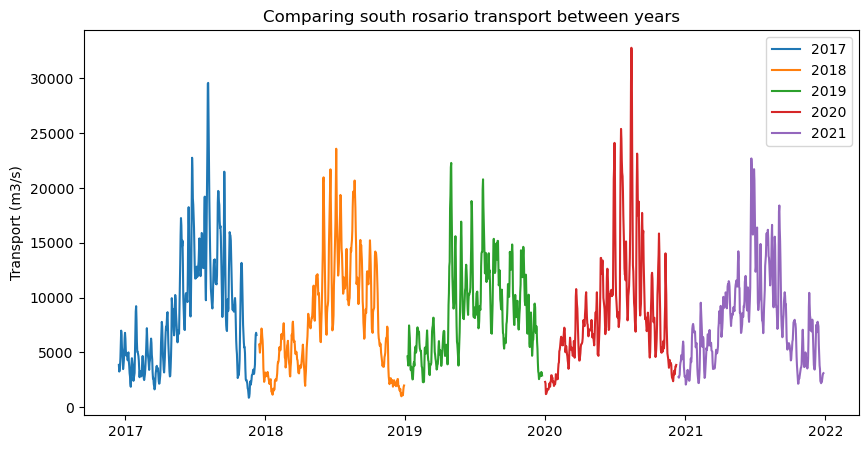

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(rostosouth_2017.dropna(),label='2017')
ax.plot(ros2south_2018,label='2018')
ax.plot(ros2south_2019,label='2019')
ax.plot(rostosouth_2020.dropna(),label='2020')
ax.plot(rostosouth_2021.dropna(),label='2021')
ax.set_title('Comparing south rosario transport between years')
ax.set_ylabel('Transport (m3/s)')
ax.legend()


No significant differences between years

In [ ]:
np.sum(rostosouth_2017.dropna()),np.sum(ros2south_2018),np.sum(ros2south_2019),np.sum(rostosouth_2020.dropna()),np.sum(rostosouth_2021.dropna())

(3003534.954942012,
 2976566.711133923,
 3032634.264763184,
 2912027.5163859343,
 2966006.0826738933)

Total transport through each strait is pretty consistent between years

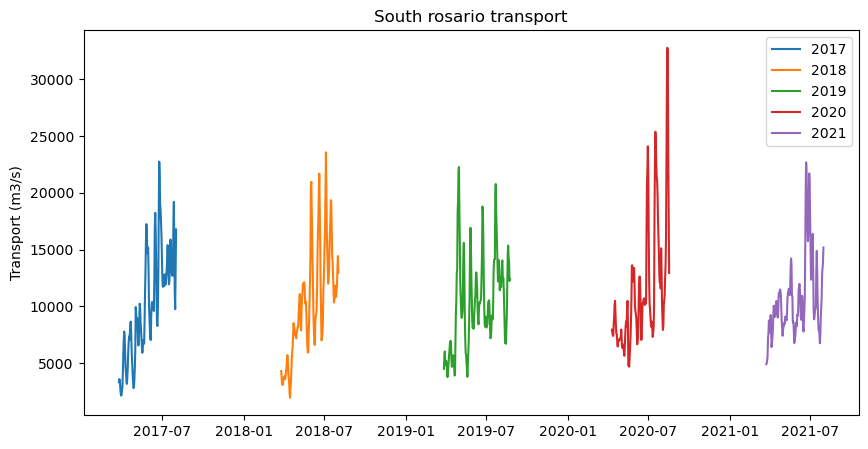

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(rostosouth_2017.dropna()[100:230],label='2017')
ax.plot(ros2south_2018[100:230],label='2018')
ax.plot(ros2south_2019[80:230],label='2019')
ax.plot(rostosouth_2020.dropna()[100:230],label='2020')
ax.plot(rostosouth_2021.dropna()[100:230],label='2021')
ax.set_title('South rosario transport')
ax.set_ylabel('Transport (m3/s)')
ax.legend()

Text(0.5, 1.0, 'Comparing difference in PRtoadm and PRtoVS for each year')

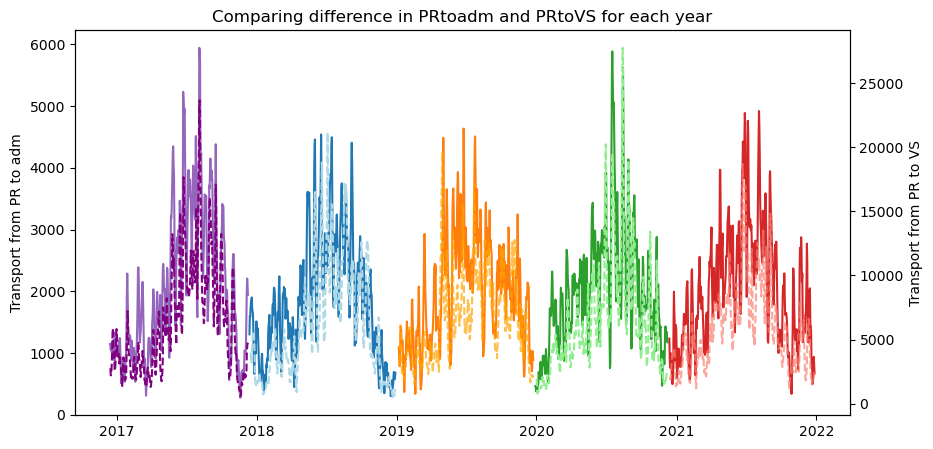

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(PRtoadm2018_ros_avg.dropna())
ax.plot(PRtoadm2019_ros_avg.dropna())
ax.plot(PRtoadm2020_ros_avg.dropna())
ax.plot(PRtoadm2021_ros_avg.dropna())
ax.plot(PRtoadm2017_ros_avg.dropna())
ax2 = ax.twinx()
ax2.plot(PRtovs2018_ros_avg.dropna(),color='lightblue',ls='--')
ax2.plot(PRtovs2019_ros_avg.dropna(),color='orange',ls='--',alpha=0.7)
ax2.plot(PRtovs2020_ros_avg.dropna(),color='lightgreen',ls='--')
ax2.plot(PRtovs2021_ros_avg.dropna(),color='salmon',ls='--',alpha=0.7)
ax2.plot(PRtovs2017_ros_avg.dropna(),color='purple',ls='--')
ax.set_ylabel('Transport from PR to adm')
ax2.set_ylabel('Transport from PR to VS')
ax.set_title('Comparing difference in PRtoadm and PRtoVS for each year')

No significant differences

### Look at proportion of PRtoadm vs. PRtoVS

(0.25938898954964124,
 0.2684121523271367,
 0.24204120107559746,
 0.26302630591421716,
 0.27073643740388775)

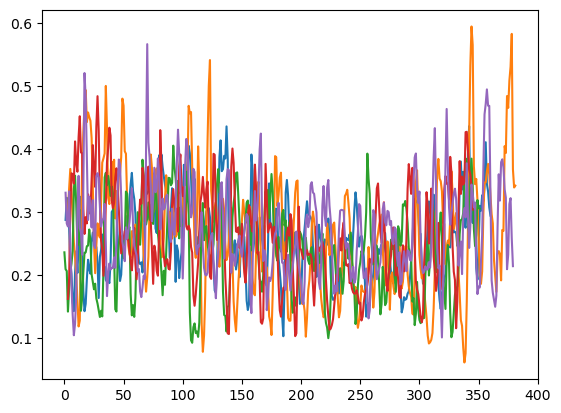

In [ ]:
prop_adm_2017 = PRtoadm2017_ros_avg.dropna()/rostosouth_2017.dropna()
prop_adm_2018 = PRtoadm2018_ros_avg.dropna()/rostosouth_2018.dropna()
prop_adm_2019 = PRtoadm2019_ros_avg.dropna()/rostosouth_2019.dropna()
prop_adm_2020 = PRtoadm2020_ros_avg.dropna()/rostosouth_2020.dropna()
prop_adm_2021 = PRtoadm2021_ros_avg.dropna()/rostosouth_2021.dropna()

plt.plot(prop_adm_2017.values)
plt.plot(prop_adm_2018.values)
plt.plot(prop_adm_2019.values)
plt.plot(prop_adm_2020.values)
plt.plot(prop_adm_2021.values)
prop_adm_2017.mean(),prop_adm_2018.mean(),prop_adm_2019.mean(),prop_adm_2020.mean(),prop_adm_2021.mean()

(0.26451466853651723,
 0.25472808671876496,
 0.2405439227230361,
 0.24422543117210208,
 0.2593445483128105)

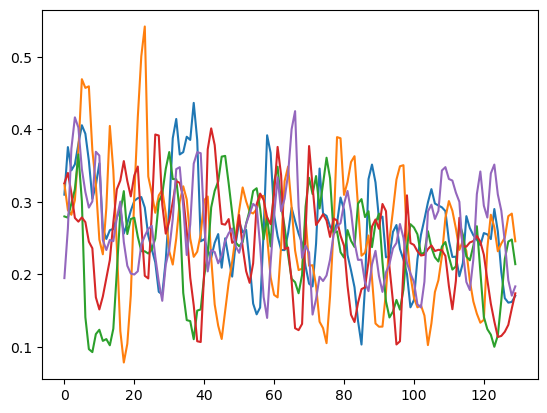

In [ ]:
plt.plot(prop_adm_2017[100:230].values)
plt.plot(prop_adm_2018[100:230].values)
plt.plot(prop_adm_2019[100:230].values)
plt.plot(prop_adm_2020[100:230].values)
plt.plot(prop_adm_2021[100:230].values)
prop_adm_2017[100:230].mean(),prop_adm_2018[100:230].mean(),prop_adm_2019[100:230].mean(),prop_adm_2020[100:230].mean(),prop_adm_2021[100:230].mean()

No significant differences

In [ ]:
## Correlations

mask = np.isin(datelist_tides,date2018_rossh)
date_tides_2018sh = np.array(datelist_tides)[mask]
tides2018 = tides.vozocrtx[mask]

mask = np.isin(datelist_tides,date2019_rossh)
date_tides_2019sh = np.array(datelist_tides)[mask]
tides2019 = tides.vozocrtx[mask]

print('----- 2018 Correlations -----')

corr,p = stats.spearmanr(densdiff_ros_2018,ros2south_2018)
print('Densdiff and Ros:',corr)
corr,p = stats.spearmanr(tides2018,res2018)
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2018,res2018)
print('Winds and Ros:',corr)

print('    -- May - August region --    ')
corr,p = stats.spearmanr(densdiff_ros_2018[100:230],ros2south_2018[100:230])
print('Densdiff and Ros:',corr)
corr,p = stats.spearmanr(tides2018[100:230],res2018[100:230])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2018[100:230],res2018[100:230])
print('Winds and Ros:',corr)

print('\n\n ----- 2019 Correlations -----')

corr,p = stats.spearmanr(densdiff_ros2019,ros2south_2019.dropna())
print('Densdiff and Ros:',corr)
corr,p = stats.spearmanr(tides2019,res2019)
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2019,res2019)
print('Winds and Ros:',corr)

print('    -- May - August region --    ')
corr,p = stats.spearmanr(densdiff_ros_2019[100:230],ros2south_2019[100:230])
print('Densdiff and Ros:',corr)
corr,p = stats.spearmanr(tides2019[100:230],res2019[100:230])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2019[100:230],res2019[100:230])
print('Winds and Ros:',corr)

print('\n\n ----- 2020 Correlations -----')

corr,p = stats.spearmanr(densdiff_ros2020,rostosouth_2020.dropna())
print('Densdiff and Ros:',corr)
corr,p = stats.spearmanr(tides2020,res2020)
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2020,res2020)
print('Winds and Ros:',corr)

print('    -- May - August region --    ')
corr,p = stats.spearmanr(densdiff_ros2020[100:230],rostosouth_2020[100:230])
print('Densdiff and Ros:',corr)
corr,p = stats.spearmanr(tides2020[100:230],res2020[100:230])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2020[100:230],res2020[100:230])
print('Winds and Ros:',corr)

print('\n\n ----- 2021 Correlations -----')

corr,p = stats.spearmanr(densdiff_ros2021,rostosouth_2021.dropna())
print('Densdiff and Ros:',corr)
corr,p = stats.spearmanr(tides2021,res2021)
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2021,res2021)
print('Winds and Ros:',corr)

print('    -- May - August region --    ')
corr,p = stats.spearmanr(densdiff_ros2021[100:230],rostosouth_2021[100:230])
print('Densdiff and Ros:',corr)
corr,p = stats.spearmanr(tides2021[100:230],res2021[100:230])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2021[100:230],res2021[100:230])
print('Winds and Ros:',corr)

----- 2018 Correlations -----
Densdiff and Ros: 0.8292558573214036
Tides and Ros: -0.12447301190531297
Winds and Ros: -0.19575566003839853
    -- May - August region --    
Densdiff and Ros: 0.7014516107006786
Tides and Ros: -0.08490898414562537
Winds and Ros: -0.07430662715590818


 ----- 2019 Correlations -----
Densdiff and Ros: 0.7061271358887469
Tides and Ros: -0.2131397691377052
Winds and Ros: -0.2873803439062376
    -- May - August region --    
Densdiff and Ros: -0.16406887981537369
Tides and Ros: -0.44461347280449004
Winds and Ros: -0.28454027775881136


 ----- 2020 Correlations -----
Densdiff and Ros: 0.7759677148340195
Tides and Ros: -0.07695702287848549
Winds and Ros: -0.17338065661047025
    -- May - August region --    
Densdiff and Ros: 0.5052178781630228
Tides and Ros: -0.24380231875349928
Winds and Ros: -0.40899916699668165


 ----- 2021 Correlations -----
Densdiff and Ros: 0.7885384002730685
Tides and Ros: 0.03969643873023097
Winds and Ros: -0.2568187507111162
    -- M

Correlation always stronger in the May - August region (either + or - )

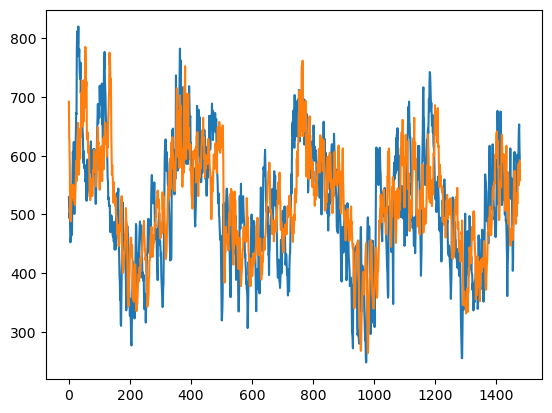

In [ ]:
plt.plot(age_2018['forpr_ros3'][4])
plt.plot(age_2018['backvs_ros3'][4])

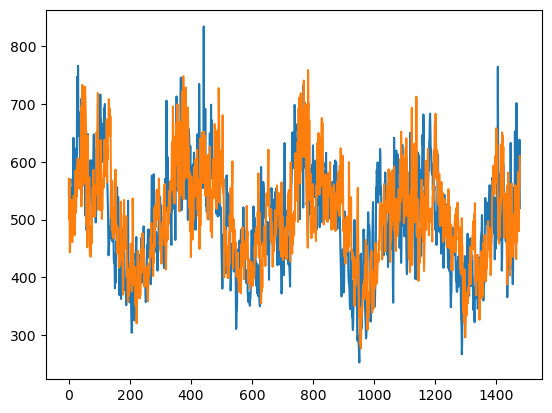

In [ ]:
plt.plot(age_2018['forpr_ros3'][2])
plt.plot(age_2018['backadm_ros3'][4])

#### 2017

In [ ]:
np.mean(prop_2017),np.mean(prop_2018),np.mean(prop_2019),np.mean(prop_2020)

(0.25938898954964124,
 0.2684121523271367,
 0.24204120107559743,
 0.26302630591421716)

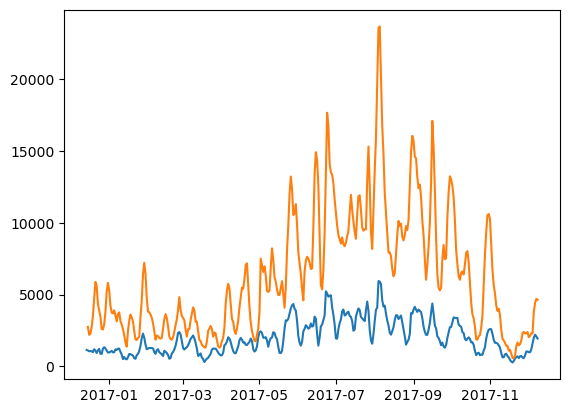

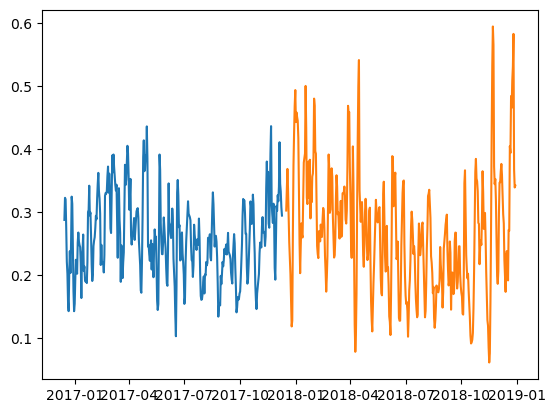

In [ ]:
plt.plot(PRtoadm2017_ros_avg.dropna())
plt.plot(PRtovs2017_ros_avg.dropna())

prop_2017 = PRtoadm2017_ros_avg.dropna()/(PRtoadm2017_ros_avg.dropna()+PRtovs2017_ros_avg.dropna())
prop_2018 = PRtoadm2018_ros_avg.dropna()/(PRtoadm2018_ros_avg.dropna()+PRtovs2018_ros_avg.dropna())
prop_2019 = PRtoadm2019_ros_avg.dropna()/(PRtoadm2019_ros_avg.dropna()+PRtovs2019_ros_avg.dropna())
prop_2020 = PRtoadm2020_ros_avg.dropna()/(PRtoadm2020_ros_avg.dropna()+PRtovs2020_ros_avg.dropna())

plt.subplots()
plt.plot(prop_2017)
plt.plot(prop_2018)

#### Entire Year

In [ ]:
corr,p = stats.spearmanr(tides2017,res2017)
print(corr)
corr,p = stats.spearmanr(tides2018,res2018)
print(corr)
corr,p = stats.spearmanr(tides2019,res2019)
print(corr)
corr,p = stats.spearmanr(tides2020,res2020)
print(corr)
corr,p = stats.spearmanr(tides2021,res2021)
print(corr)

-0.17941547902890195
-0.12447301190531297
-0.19524840912942892
-0.08030696104285392
0.020602517727916974


Look at split up difference b/w whole yr and region

In [108]:
print('-- Residual rosario flow --')
corr,p = stats.spearmanr(tides2017,res2017)
print('2017, full:',corr)
corr,p = stats.spearmanr(tides2017[135:255],res2017[135:255])
print('2017, sum:',corr)
corr,p = stats.spearmanr(tides_2018,res_2018)
print('2018, full:',corr)
corr,p = stats.spearmanr(tides_2018[110:240],res_2018[110:240])
print('2018, sum:',corr)
corr,p = stats.spearmanr(tides_2019,res_2019)
print('2019, full:',corr)
corr,p = stats.spearmanr(tides_2019[110:240],res_2019[110:240])
print('2019, sum:',corr)
corr,p = stats.spearmanr(tides2020,res2020)
print('2020, full:',corr)
corr,p = stats.spearmanr(tides2020[110:240],res2020[110:240])
print('2020, sum:',corr)
corr,p = stats.spearmanr(tides2021,res2021)
print('2021, full:',corr)
corr,p = stats.spearmanr(tides2021[110:240],res2021[110:240])
print('2021, sum:',corr)

-- Residual rosario flow --
2017, full: -0.17941547902890195
2017, sum: 0.01729981248697826
2018, full: -0.18000961065813167
2018, sum: -0.14166791844760954
2019, full: -0.1750980525782717
2019, sum: -0.21802018326073005
2020, full: -0.08030696104285392
2020, sum: -0.21818951508282236
2021, full: 0.020602517727916974
2021, sum: -0.20217946441983367


In [105]:
print('-- Residual pr to adm (rosario flow) --')
corr_2017,p = stats.spearmanr(tides_prtoadm2017,res_prtoadm2017)
print('2017, full:',corr_2017)
corr_2017,p = stats.spearmanr(tides_prtoadm2017[135:255],res_prtoadm2017[135:255])
print('2017, sum:',corr_2017)
corr_2018,p = stats.spearmanr(tides_prtoadm2018,res_prtoadm2018)
print('2018, full:',corr_2018)
corr_2018,p = stats.spearmanr(tides_prtoadm2018[110:240],res_prtoadm2018[110:240])
print('2018, full:',corr_2018)
corr_2019,p = stats.spearmanr(tides_prtoadm2019,res_prtoadm2019)
print('2019, full:',corr_2019)
corr_2019,p = stats.spearmanr(tides_prtoadm2019[90:220],res_prtoadm2019[90:220])
print('2019, full:',corr_2019)
corr_2020,p = stats.spearmanr(tides_prtoadm2020,res_prtoadm2020)
print('2020, full:',corr_2020)
corr_2020,p = stats.spearmanr(tides_prtoadm2020[110:240],res_prtoadm2020[110:240])
print('2020, full:',corr_2020)
corr_2021,p = stats.spearmanr(tides_prtoadm2021,res_prtoadm2021)
print('2021, full:',corr_2021)
corr_2021,p = stats.spearmanr(tides_prtoadm2021[120:250],res_prtoadm2021[120:250])
print('2021, full:',corr_2021)

-- Residual pr to adm (rosario flow) --
2017, full: 0.0930439285185922
2017, sum: 0.3873046739356899
2018, full: 0.33405802163537945
2018, full: 0.5629163309617775
2019, full: -0.14534839570250335
2019, full: -0.2616094716574035
2020, full: 0.24361891283706316
2020, full: 0.1691051359434104
2021, full: 0.2659943336828765
2021, full: 0.2040803506807412


In [107]:
print('-- Residual pr to vs (rosario flow) --')
corr_2017,p = stats.spearmanr(tides_prtovs2017,res_prtovs2017)
print('2017, full:',corr_2017)
corr_2017,p = stats.spearmanr(tides_prtovs2017[135:255],res_prtovs2017[135:255])
print('2017, sum:',corr_2017)
corr_2018,p = stats.spearmanr(tides_prtovs2018,res_prtovs2018)
print('2018, full:',corr_2018)
corr_2018,p = stats.spearmanr(tides_prtovs2018[110:240],res_prtovs2018[110:240])
print('2018, sum:',corr_2018)
corr_2019,p = stats.spearmanr(tides_prtovs2019,res_prtovs2019)
print('2019, full:',corr_2019)
corr_2019,p = stats.spearmanr(tides_prtovs2019[90:220],res_prtovs2019[90:220])
print('2019, sum:',corr_2019)
corr_2020,p = stats.spearmanr(tides_prtovs2020,res_prtovs2020)
print('2020, full:',corr_2020)
corr_2020,p = stats.spearmanr(tides_prtovs2020[110:240],res_prtovs2020[110:240])
print('2020, sum:',corr_2020)
corr_2021,p = stats.spearmanr(tides_prtovs2021,res_prtovs2021)
print('2021, full:',corr_2021)
corr_2021,p = stats.spearmanr(tides_prtovs2021[120:250],res_prtovs2021[120:250])
print('2021, sum:',corr_2021)

-- Residual pr to adm (rosario flow) --
2017, full: -0.24213587038994638
2017, sum: -0.07363011320230571
2018, full: -0.18961034953258254
2018, sum: -0.16044190143249257
2019, full: -0.17728598584878896
2019, sum: -0.3651913859263406
2020, full: -0.13305035250680092
2020, sum: -0.25834300618607375
2021, full: -0.05088601010000815
2021, sum: -0.2925316472982015


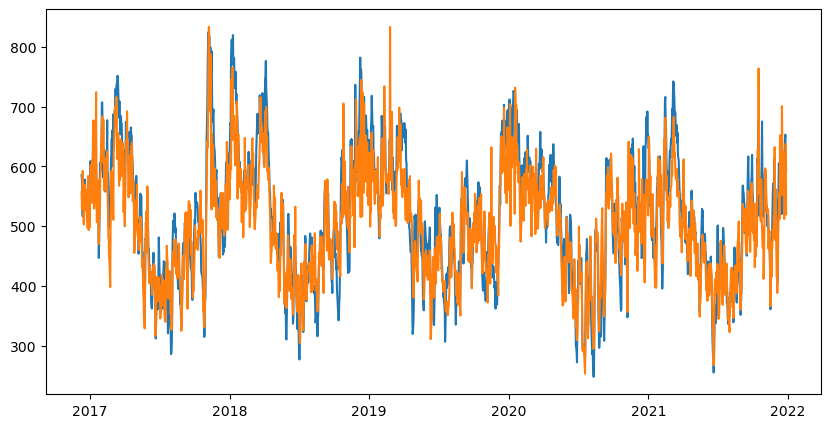

In [114]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(datelist_vs,age_2018['forpr_ros3'][4])
ax.plot(datelist_vs,age_2018['forpr_ros3'][2])

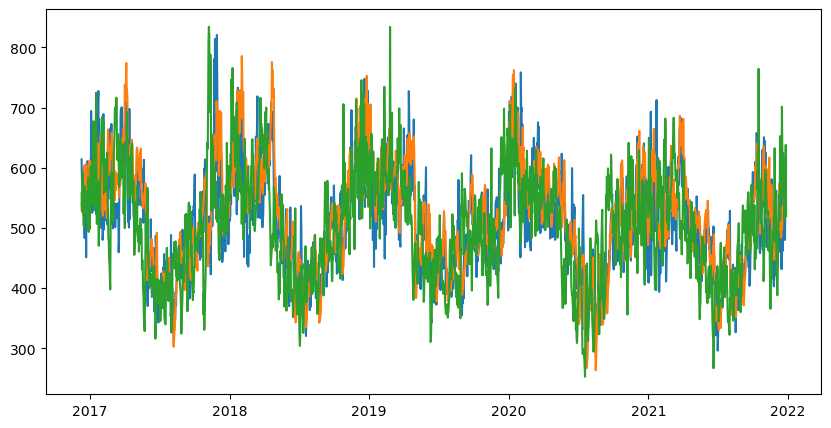

In [117]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(datelist_vs,age_2018['backadm_ros3'][4])
ax.plot(datelist_vs,age_2018['backvs_ros3'][4])
ax.plot(datelist_vs,age_2018['forpr_ros3'][2])

#### Look at correlations with wind magnitude

In [127]:
winds_prtovs2017_mag =  np.abs(winds_prtovs2017)
winds_prtovs2018_mag =  np.abs(winds_prtovs2018)
winds_prtovs2019_mag =  np.abs(winds_prtovs2019)
winds_prtovs2020_mag =  np.abs(winds_prtovs2020)
winds_prtovs2021_mag =  np.abs(winds_prtovs2021)

corr,p = stats.spearmanr(winds_prtovs2017_mag,res_prtovs2017)
print(corr)
corr,p = stats.spearmanr(winds_prtovs2018_mag,res_prtovs2018)
print(corr)
corr,p = stats.spearmanr(winds_prtovs2019_mag,res_prtovs2019)
print(corr)
corr,p = stats.spearmanr(winds_prtovs2020_mag,res_prtovs2020)
print(corr)
corr,p = stats.spearmanr(winds_prtovs2021_mag,res_prtovs2021)
print(corr)

0.012904677762431293
0.04632579690210575
0.015266459185410546
0.12575547792119118
0.035371410055481715


Nothing with wind magnitude

#### Look at correlation between winds and tides

In [136]:
print('-- Winds and Tides --')
corr_2017,p = stats.spearmanr(tides_prtoadm2017,winds_prtoadm2017)
print('2017, full:',corr_2017)
corr_2017,p = stats.spearmanr(tides_prtoadm2017[135:255],winds_prtoadm2017[135:255])
print('2017, sum:',corr_2017)
corr_2018,p = stats.spearmanr(tides_prtoadm2018,winds_prtoadm2018)
print('2018, full:',corr_2018)
corr_2018,p = stats.spearmanr(tides_prtoadm2018[110:240],winds_prtoadm2018[110:240])
print('2018, full:',corr_2018)
corr_2019,p = stats.spearmanr(tides_prtoadm2019,winds_prtoadm2019)
print('2019, full:',corr_2019)
corr_2019,p = stats.spearmanr(tides_prtoadm2019[90:220],winds_prtoadm2019[90:220])
print('2019, full:',corr_2019)
corr_2020,p = stats.spearmanr(tides_prtoadm2020,winds_prtoadm2020)
print('2020, full:',corr_2020)
corr_2020,p = stats.spearmanr(tides_prtoadm2020[110:240],winds_prtoadm2020[110:240])
print('2020, full:',corr_2020)
corr_2021,p = stats.spearmanr(tides_prtoadm2021,winds_prtoadm2021)
print('2021, full:',corr_2021)
corr_2021,p = stats.spearmanr(tides_prtoadm2021[120:250],winds_prtoadm2021[120:250])
print('2021, full:',corr_2021)

-- Winds and Tides --
2017, full: -0.07637471113083667
2017, sum: -0.2257240086117091
2018, full: -0.0120649946165038
2018, full: -0.443701265891928
2019, full: 0.023637992476519386
2019, full: 0.10093542175913914
2020, full: 0.08816589689529974
2020, full: 0.23560884349096664
2021, full: 0.13632446062281378
2021, full: 0.24712340739324584
